<a href="https://colab.research.google.com/github/Omkarnj/Algorithmic-Trading-Unsupervised-and-clustering-methods/blob/main/Algorithmic_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Quant Strategies using clustering to identify similar risk and return characteristics

# Unsupervised Learning Trading Strategy -

* Download/Load NIFTY50 stocks prices data.
* Calculate different features and indicators on each stock.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to NIFTY50 returns.

\


# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load NIFTY50 stocks prices data.

In [151]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [152]:
!pip install pandas_ta
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

nifty50 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nifty50list.csv")


symbols_list = nifty50['Symbol'].unique().tolist()

end_date = '2024-02-14'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                  end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  50 of 50 completed


Price                       adj close        close          high          low  \
date       ticker                                                               
2016-02-16 ADANIENT.NS      33.302738    34.356022     36.344910    34.138062   
           ADANIPORTS.NS   191.545212   200.350006    204.350006   193.750000   
           APOLLOHOSP.NS  1383.241821  1424.199951   1455.000000  1413.000000   
           ASIANPAINT.NS   795.939209   840.299988    860.150024   836.099976   
           AXISBANK.NS     396.625916   405.799988    422.500000   405.000000   
...                               ...          ...           ...          ...   
2024-02-13 TECHM.NS       1328.449951  1328.449951   1334.800049  1300.000000   
           TITAN.NS       3559.949951  3559.949951   3608.750000  3551.149902   
           ULTRACEMCO.NS  9852.400391  9852.400391  10004.700195  9830.599609   
           UPL.NS          479.100006   479.100006    479.950012   452.149994   
           WIPRO.NS        511.600006   511.600006    513.000000   491.700012   

Price                            open      volume  
date       ticker                                  
2016-02-16 ADANIENT.NS      36.181442   7678551.0  
           ADANIPORTS.NS   195.500000   9113057.0  
           APOLLOHOSP.NS  1441.500000    127262.0  
           ASIANPAINT.NS   855.049988    985215.0  
           AXISBANK.NS     420.799988  12445006.0  
...                               ...         ...  
2024-02-13 TECHM.NS       1321.949951   1127361.0  
           TITAN.NS       3607.000000    796060.0  
           ULTRACEMCO.NS  9997.799805    276453.0  
           UPL.NS          462.049988   7706461.0  
           WIPRO.NS        503.100006  11186788.0  

[97761 rows x 6 columns]

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 97761 entries, (Timestamp('2016-02-16 00:00:00'), 'ADANIENT.NS') to (Timestamp('2024-02-13 00:00:00'), 'WIPRO.NS')
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   adj close  97761 non-null  float64
 1   close      97761 non-null  float64
 2   high       97761 non-null  float64
 3   low        97761 non-null  float64
 4   open       97761 non-null  float64
 5   volume     97761 non-null  float64
dtypes: float64(6)
memory usage: 4.8+ MB


## 2. Calculate features and technical indicators for each stock.

1. **Garman-Klass Volatility** - It is a volatility measure usually used in forex, but it works in stocks as well. it is the approximation to measure the intraday volatility of a given asset. It incorporates information from open, low, high, and close prices. It aims to improve upon other volatility estimators by considering both intraday and closing data.

2. **RSI** - Relative Strength Index measures the speed and magnitude of a security's recent price changes to evaluate overvalued or undervalued conditions in the price of that security. The RSI is displayed as an oscillator (a line graph) on a scale of zero to 100.

3. **Bollinger Bands** - Bollinger Bands® is a technical analysis tool to generate oversold or overbought signals and was developed by John Bollinger.
Three lines compose Bollinger Bands: A simple moving average, or the middle band, and an upper and lower band. The upper and lower bands are typically 2 standard deviations +/- from a 20-day simple moving average and can be modified.

4. **ATR** - (Average True range) It was developed by J. Welles Wilder, and its primary purpose is to assess the degree of price volatility over a specific period. Traders and analysts commonly use the ATR to make decisions related to risk management and setting stop-loss levels. It can be used to identify potential breakouts or breakdowns by comparing ATR values to historical levels.

5. **MACD** - (Moving Average Convergence Divergence) It is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price. Traders use MACD to identify the strength and direction of a trend. Positive values indicate upward momentum, while negative values indicate downward momentum.
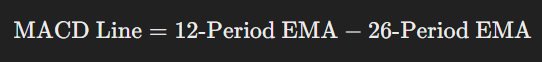

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

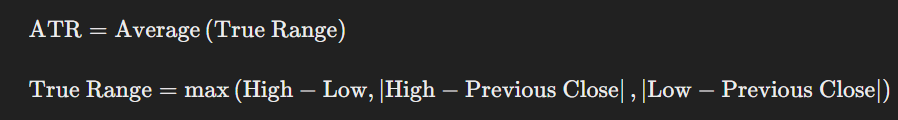

### Adding the columns to our dataframe

In [154]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
# groupby level = 1 because we're doing it at the ticker level column (it is multi-index), level 0 is date, and lvl 1 is ticker.

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

#Using iloc here because the pandas_ta.bbands function actually returns 5 columns - BBL, BBM, BBU, BBB, BBP. Hence we only want the first 3 - lower, mid, upper,
# hence we are using iloc to only get those specific columns and add them to our df one by one.

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)



#lets try to plot a sample -
# print(df.head(10))
# df.xs('ADANIENT.NS', level=1)['rsi'].plot()
df

Price                       adj close        close          high          low  \
date       ticker                                                               
2016-02-16 ADANIENT.NS      33.302738    34.356022     36.344910    34.138062   
           ADANIPORTS.NS   191.545212   200.350006    204.350006   193.750000   
           APOLLOHOSP.NS  1383.241821  1424.199951   1455.000000  1413.000000   
           ASIANPAINT.NS   795.939209   840.299988    860.150024   836.099976   
           AXISBANK.NS     396.625916   405.799988    422.500000   405.000000   
...                               ...          ...           ...          ...   
2024-02-13 TECHM.NS       1328.449951  1328.449951   1334.800049  1300.000000   
           TITAN.NS       3559.949951  3559.949951   3608.750000  3551.149902   
           ULTRACEMCO.NS  9852.400391  9852.400391  10004.700195  9830.599609   
           UPL.NS          479.100006   479.100006    479.950012   452.149994   
           WIPRO.NS        511.600006   511.600006    513.000000   491.700012   

Price                            open      volume  garman_klass_vol  \
date       ticker                                                     
2016-02-16 ADANIENT.NS      36.181442   7678551.0         -0.000693   
           ADANIPORTS.NS   195.500000   9113057.0          0.001257   
           APOLLOHOSP.NS  1441.500000    127262.0         -0.000228   
           ASIANPAINT.NS   855.049988    985215.0         -0.001580   
           AXISBANK.NS     420.799988  12445006.0         -0.000457   
...                               ...         ...               ...   
2024-02-13 TECHM.NS       1321.949951   1127361.0          0.000340   
           TITAN.NS       3607.000000    796060.0          0.000063   
           ULTRACEMCO.NS  9997.799805    276453.0          0.000071   
           UPL.NS          462.049988   7706461.0          0.001273   
           WIPRO.NS        503.100006  11186788.0          0.000791   

Price                           rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2016-02-16 ADANIENT.NS          NaN       NaN       NaN       NaN       NaN   
           ADANIPORTS.NS        NaN       NaN       NaN       NaN       NaN   
           APOLLOHOSP.NS        NaN       NaN       NaN       NaN       NaN   
           ASIANPAINT.NS        NaN       NaN       NaN       NaN       NaN   
           AXISBANK.NS          NaN       NaN       NaN       NaN       NaN   
...                             ...       ...       ...       ...       ...   
2024-02-13 TECHM.NS       54.226721  7.159317  7.197710  7.236102  1.132356   
           TITAN.NS       44.584182  8.155348  8.212507  8.269666  2.384138   
           ULTRACEMCO.NS  49.550379  9.186445  9.210034  9.233623  2.474421   
           UPL.NS         33.891326  6.105863  6.250225  6.394586 -0.116624   
           WIPRO.NS       66.187070  6.138975  6.184831  6.230686  1.756052   

Price                         macd  
date       ticker                   
2016-02-16 ADANIENT.NS         NaN  
           ADANIPORTS.NS       NaN  
           APOLLOHOSP.NS       NaN  
           ASIANPAINT.NS       NaN  
           AXISBANK.NS         NaN  
...                            ...  
2024-02-13 TECHM.NS       0.364820  
           TITAN.NS      -1.361541  
           ULTRACEMCO.NS -0.010558  
           UPL.NS        -2.228064  
           WIPRO.NS       1.451753  

[97761 rows x 13 columns]

In [155]:
df.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 97761 entries, (Timestamp('2016-02-16 00:00:00'), 'ADANIENT.NS') to (Timestamp('2024-02-13 00:00:00'), 'WIPRO.NS')
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   adj close         97761 non-null  float64
 1   close             97761 non-null  float64
 2   high              97761 non-null  float64
 3   low               97761 non-null  float64
 4   open              97761 non-null  float64
 5   volume            97761 non-null  float64
 6   garman_klass_vol  97761 non-null  float64
 7   rsi               96761 non-null  float64
 8   bb_low            96811 non-null  float64
 9   bb_mid            96811 non-null  float64
 10  bb_high           96811 non-null  float64
 11  atr               97061 non-null  float64
 12  macd              96511 non-null  float64
dtypes: float64(13)
memory usage: 10.1+ MB


## 3. Aggregate to monthly level

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

### Here, we are only including the calculated indicators columns and removing the rest
We are using the iteration method so we don't lose the multi-index nature of the data

In [156]:
last_cols = [c for c in df.columns.unique(0) if c not in [ 'volume', 'open',
                                                          'high', 'low', 'close']]

data = df.unstack()[last_cols].resample('M').last().stack('ticker').dropna()

data

Price                       adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                               
2016-03-31 ADANIENT.NS      39.402477 -0.736849  3.695146  3.490645  3.592896   
           ADANIPORTS.NS   237.887405 -0.913847  5.493406  5.322734  5.408070   
           APOLLOHOSP.NS  1296.623047 -0.700795  7.274361  7.151769  7.213065   
           ASIANPAINT.NS   822.555847 -1.180314  6.751814  6.684154  6.717984   
           AXISBANK.NS     434.108948 -1.028351  6.093734  5.962331  6.028032   
...                               ...       ...       ...       ...       ...   
2024-02-29 TECHM.NS       1328.449951  1.132356  7.236102  7.159317  7.197710   
           TITAN.NS       3559.949951  2.384138  8.269666  8.155348  8.212507   
           ULTRACEMCO.NS  9852.400391  2.474421  9.233623  9.186445  9.210034   
           UPL.NS          479.100006 -0.116624  6.394586  6.105863  6.250225   
           WIPRO.NS        511.600006  1.756052  6.230686  6.138975  6.184831   

Price                     garman_klass_vol      macd        rsi  
date       ticker                                                
2016-03-31 ADANIENT.NS            0.000513 -0.129920  71.790829  
           ADANIPORTS.NS         -0.000094  0.540688  73.169335  
           APOLLOHOSP.NS          0.000792 -0.677222  35.178927  
           ASIANPAINT.NS         -0.001550 -0.242745  51.883335  
           AXISBANK.NS            0.000112  0.855402  64.103108  
...                                    ...       ...        ...  
2024-02-29 TECHM.NS               0.000340  0.364820  54.226721  
           TITAN.NS               0.000063 -1.361541  44.584182  
           ULTRACEMCO.NS          0.000071 -0.010558  49.550379  
           UPL.NS                 0.001273 -2.228064  33.891326  
           WIPRO.NS               0.000791  1.451753  66.187070  

[4754 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

 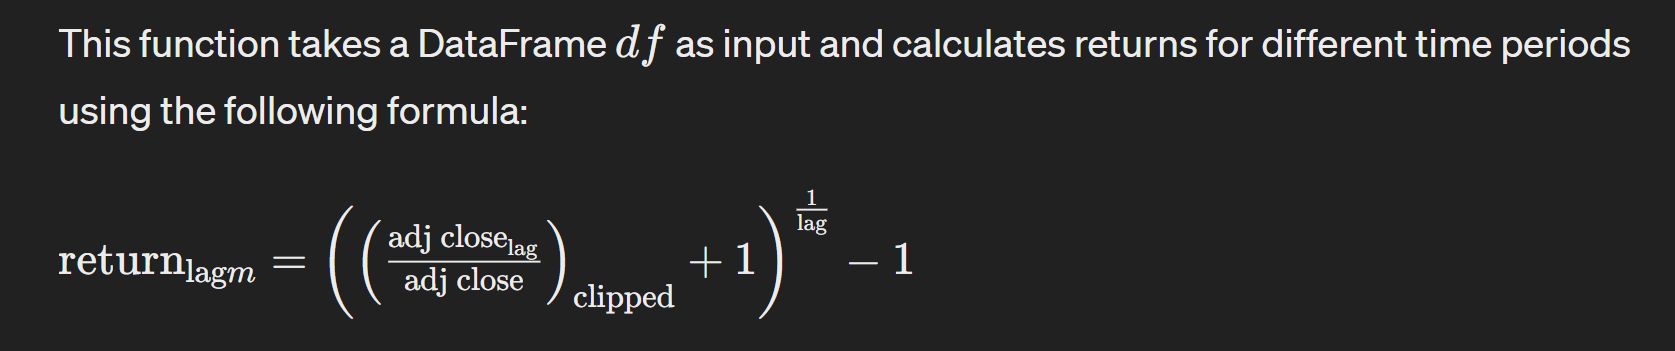

In [157]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df

# In summary, this part of the code is applying a clipping operation to the DataFrame. It clips the values in the DataFrame to be within
# a range defined by the quantiles of the data, specifically using the quantile defined by outlier_cutoff as the lower bound and 1 - outlier_cutoff as the upper bound.

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

Price                       adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                               
2017-03-31 ADANIENT.NS      57.955818 -0.730948  4.094287  3.917253  4.005770   
           ADANIPORTS.NS   326.146881 -0.935862  5.799313  5.645352  5.722332   
           APOLLOHOSP.NS  1136.508179 -1.041104  7.122516  7.012271  7.067394   
           ASIANPAINT.NS  1024.793335 -1.200976  6.956817  6.874274  6.915546   
           AXISBANK.NS     484.190033 -0.962820  6.255885  6.165180  6.210532   
...                               ...       ...       ...       ...       ...   
2024-02-29 TECHM.NS       1328.449951  1.132356  7.236102  7.159317  7.197710   
           TITAN.NS       3559.949951  2.384138  8.269666  8.155348  8.212507   
           ULTRACEMCO.NS  9852.400391  2.474421  9.233623  9.186445  9.210034   
           UPL.NS          479.100006 -0.116624  6.394586  6.105863  6.250225   
           WIPRO.NS        511.600006  1.756052  6.230686  6.138975  6.184831   

Price                     garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                            
2017-03-31 ADANIENT.NS            0.001078 -0.128790  67.437676   0.102031   
           ADANIPORTS.NS         -0.000675  0.279592  68.082276   0.125435   
           APOLLOHOSP.NS          0.000025 -0.622978  39.940351  -0.104867   
           ASIANPAINT.NS         -0.000628  0.200958  61.406746   0.048135   
           AXISBANK.NS            0.000067 -0.236393  47.576604  -0.031284   
...                                    ...       ...        ...        ...   
2024-02-29 TECHM.NS               0.000340  0.364820  54.226721  -0.003899   
           TITAN.NS               0.000063 -1.361541  44.584182  -0.037214   
           ULTRACEMCO.NS          0.000071 -0.010558  49.550379  -0.030977   
           UPL.NS                 0.001273 -2.228064  33.891326  -0.108983   
           WIPRO.NS               0.000791  1.451753  66.187070   0.069957   

Price                     return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2017-03-31 ADANIENT.NS     0.116044   0.123470   0.087287   0.025222   
           ADANIPORTS.NS   0.075947   0.081521   0.047714   0.056632   
           APOLLOHOSP.NS  -0.026738  -0.004184  -0.019764  -0.013395   
           ASIANPAINT.NS   0.051619   0.064061  -0.012524   0.007820   
           AXISBANK.NS     0.026265   0.029390  -0.016205  -0.008201   
...                             ...        ...        ...        ...   
2024-02-29 TECHM.NS        0.021688   0.028527   0.018637   0.026718   
           TITAN.NS       -0.015838   0.006579   0.023081   0.026466   
           ULTRACEMCO.NS  -0.031469   0.030484   0.029042   0.025795   
           UPL.NS         -0.096763  -0.056623  -0.034420  -0.037220   
           WIPRO.NS        0.042988   0.074693   0.038632   0.026926   

Price                     return_12m  
date       ticker                     
2017-03-31 ADANIENT.NS      0.032677  
           ADANIPORTS.NS    0.026645  
           APOLLOHOSP.NS   -0.010923  
           ASIANPAINT.NS    0.018488  
           AXISBANK.NS      0.009140  
...                              ...  
2024-02-29 TECHM.NS         0.021147  
           TITAN.NS         0.034663  
           ULTRACEMCO.NS    0.026146  
           UPL.NS          -0.029115  
           WIPRO.NS         0.023703  

[4154 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* The Fama-French three-factor model is an asset pricing model developed by Eugene Fama and Kenneth French. The three factors are:

  * Market Risk (MKT):

    Represents the excess return of the market over the risk-free rate.
    This factor captures the systematic risk associated with the overall market.
  * Size (SMB - Small Minus Big):

    Represents the historic average return difference between small-cap stocks and large-cap stocks.
    It reflects the idea that small-cap stocks tend to outperform large-cap stocks over time.
  * Value (HML - High Minus Low):

    Represents the historic average return difference between value stocks and growth stocks.
    It reflects the idea that value stocks (those with lower price-to-book ratios) tend to outperform growth stocks (those with higher price-to-book ratios).


* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures.![output.png]()

In [158]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-03-31 ADANIENT.NS    0.0017  0.0074 -0.0335  0.0061 -0.0094   0.102031
           ADANIPORTS.NS  0.0017  0.0074 -0.0335  0.0061 -0.0094   0.125435
           APOLLOHOSP.NS  0.0017  0.0074 -0.0335  0.0061 -0.0094  -0.104867
           ASIANPAINT.NS  0.0017  0.0074 -0.0335  0.0061 -0.0094   0.048135
           AXISBANK.NS    0.0017  0.0074 -0.0335  0.0061 -0.0094  -0.031284
...                          ...     ...     ...     ...     ...        ...
2024-01-31 TECHM.NS       0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.047931
           TITAN.NS       0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.006013
           ULTRACEMCO.NS  0.0070 -0.0573 -0.0239  0.0068 -0.0095  -0.031962
           UPL.NS         0.0070 -0.0573 -0.0239  0.0068 -0.0095  -0.084376
           WIPRO.NS       0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.016698

[4104 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [159]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-03-31 ADANIENT.NS    0.0017  0.0074 -0.0335  0.0061 -0.0094   0.102031
           ADANIPORTS.NS  0.0017  0.0074 -0.0335  0.0061 -0.0094   0.125435
           APOLLOHOSP.NS  0.0017  0.0074 -0.0335  0.0061 -0.0094  -0.104867
           ASIANPAINT.NS  0.0017  0.0074 -0.0335  0.0061 -0.0094   0.048135
           AXISBANK.NS    0.0017  0.0074 -0.0335  0.0061 -0.0094  -0.031284
...                          ...     ...     ...     ...     ...        ...
2024-01-31 TECHM.NS       0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.047931
           TITAN.NS       0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.006013
           ULTRACEMCO.NS  0.0070 -0.0573 -0.0239  0.0068 -0.0095  -0.031962
           UPL.NS         0.0070 -0.0573 -0.0239  0.0068 -0.0095  -0.084376
           WIPRO.NS       0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.016698

[4104 rows x 6 columns]

In [160]:
factor_data.groupby(level=1).size()

ticker
ADANIENT.NS      83
ADANIPORTS.NS    83
APOLLOHOSP.NS    83
ASIANPAINT.NS    83
AXISBANK.NS      83
BAJAJ-AUTO.NS    83
BAJAJFINSV.NS    83
BAJFINANCE.NS    83
BHARTIARTL.NS    83
BPCL.NS          83
BRITANNIA.NS     83
CIPLA.NS         83
COALINDIA.NS     83
DIVISLAB.NS      83
DRREDDY.NS       83
EICHERMOT.NS     83
GRASIM.NS        83
HCLTECH.NS       83
HDFCBANK.NS      83
HDFCLIFE.NS      62
HEROMOTOCO.NS    83
HINDALCO.NS      83
HINDUNILVR.NS    83
ICICIBANK.NS     83
INDUSINDBK.NS    83
INFY.NS          83
ITC.NS           83
JSWSTEEL.NS      83
KOTAKBANK.NS     83
LT.NS            83
LTIM.NS          78
M&M.NS           83
MARUTI.NS        83
NESTLEIND.NS     83
NTPC.NS          83
ONGC.NS          83
POWERGRID.NS     83
RELIANCE.NS      83
SBILIFE.NS       63
SBIN.NS          83
SUNPHARMA.NS     83
TATACONSUM.NS    83
TATAMOTORS.NS    83
TATASTEEL.NS     83
TCS.NS           83
TECHM.NS         83
TITAN.NS         83
ULTRACEMCO.NS    83
UPL.NS           83
WIPRO.NS     

## Calculate Rolling Factor Betas.
Rolling factor betas refer to the calculation of factor betas over a rolling window of historical data. Factor betas are coefficients that measure the sensitivity of an asset's returns to the returns of a particular factor, often in the context of factor models in finance. Common factors include market returns (captured by the market index), size (captured by the size factor), value (captured by the value factor), and others.

In [161]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                         
2017-03-31 ADANIENT.NS         NaN       NaN       NaN       NaN       NaN
           ADANIPORTS.NS       NaN       NaN       NaN       NaN       NaN
           APOLLOHOSP.NS       NaN       NaN       NaN       NaN       NaN
           ASIANPAINT.NS       NaN       NaN       NaN       NaN       NaN
           AXISBANK.NS         NaN       NaN       NaN       NaN       NaN
...                            ...       ...       ...       ...       ...
2024-01-31 TECHM.NS       0.825522 -0.807641  0.461390 -0.859084 -0.662018
           TITAN.NS       0.554132 -0.545913  0.254969 -0.803314 -0.402479
           ULTRACEMCO.NS  0.706252  0.452612 -0.091220  0.312067 -0.175493
           UPL.NS         1.110814  0.047141 -0.595457  0.230834  1.099032
           WIPRO.NS       0.713634 -0.284435  0.123269 -0.910412  0.050073

[4104 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [162]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4154 entries, (Timestamp('2017-03-31 00:00:00', freq='M'), 'ADANIENT.NS') to (Timestamp('2024-02-29 00:00:00', freq='M'), 'WIPRO.NS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               4154 non-null   float64
 1   bb_high           4154 non-null   float64
 2   bb_low            4154 non-null   float64
 3   bb_mid            4154 non-null   float64
 4   garman_klass_vol  4154 non-null   float64
 5   macd              4154 non-null   float64
 6   rsi               4154 non-null   float64
 7   return_1m         4154 non-null   float64
 8   return_2m         4154 non-null   float64
 9   return_3m         4154 non-null   float64
 10  return_6m         4154 non-null   float64
 11  return_9m         4154 non-null   float64
 12  return_12m        4154 non-null   float64
 13  Mkt-RF            4154 non-null   float64
 14  SMB               4154 non

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. Decide which Clustering Algorithm we should use to group similar assets based on their features.



In [163]:
data.head()

atr   bb_high    bb_low    bb_mid  \
date       ticker                                                  
2017-03-31 ADANIENT.NS   -0.730948  4.094287  3.917253  4.005770   
           ADANIPORTS.NS -0.935862  5.799313  5.645352  5.722332   
           APOLLOHOSP.NS -1.041104  7.122516  7.012271  7.067394   
           ASIANPAINT.NS -1.200976  6.956817  6.874274  6.915546   
           AXISBANK.NS   -0.962820  6.255885  6.165180  6.210532   

                          garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                            
2017-03-31 ADANIENT.NS            0.001078 -0.128790  67.437676   0.102031   
           ADANIPORTS.NS         -0.000675  0.279592  68.082276   0.125435   
           APOLLOHOSP.NS          0.000025 -0.622978  39.940351  -0.104867   
           ASIANPAINT.NS         -0.000628  0.200958  61.406746   0.048135   
           AXISBANK.NS            0.000067 -0.236393  47.576604  -0.031284   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2017-03-31 ADANIENT.NS     0.116044   0.123470   0.087287   0.025222   
           ADANIPORTS.NS   0.075947   0.081521   0.047714   0.056632   
           APOLLOHOSP.NS  -0.026738  -0.004184  -0.019764  -0.013395   
           ASIANPAINT.NS   0.051619   0.064061  -0.012524   0.007820   
           AXISBANK.NS     0.026265   0.029390  -0.016205  -0.008201   

                          return_12m    Mkt-RF       SMB       HML       RMW  \
date       ticker                                                              
2017-03-31 ADANIENT.NS      0.032677  0.399011 -0.558664  0.362638  1.831222   
           ADANIPORTS.NS    0.026645  0.233206  0.111426  0.483611  0.316408   
           APOLLOHOSP.NS   -0.010923  0.376735 -0.403773  0.228662 -0.186724   
           ASIANPAINT.NS    0.018488  0.120956  0.165311  0.185990  0.403778   
           AXISBANK.NS      0.009140  0.845733  0.197412  0.411331 -0.412963   

                               CMA  
date       ticker                   
2017-03-31 ADANIENT.NS   -0.459757  
           ADANIPORTS.NS -0.629419  
           APOLLOHOSP.NS -1.359338  
           ASIANPAINT.NS -0.261540  
           AXISBANK.NS    0.040799

### Heirarchical clustering

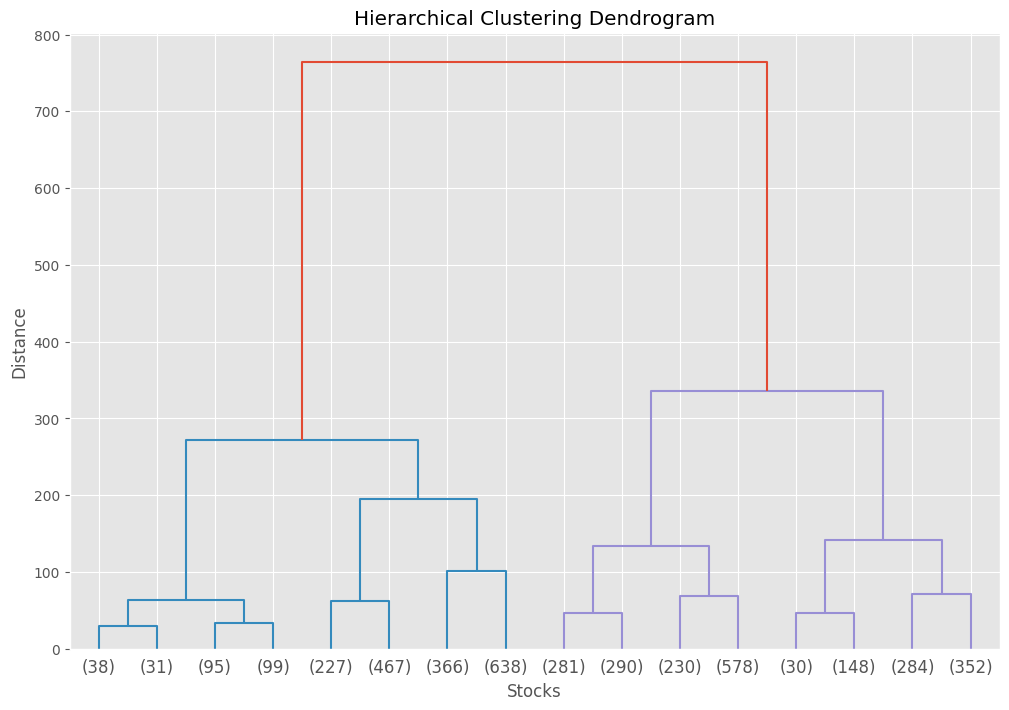

In [164]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Define a function to perform hierarchical clustering and visualize the dendrogram
def hierarchical_clustering(data):

    X = data.dropna()  # Exclude non-numeric columns and drop rows with missing values

    # Specify the number of clusters (you can adjust this based on your needs)
    n_clusters = 4

    # Hierarchical clustering
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    data['cluster'] = agg_clustering.fit_predict(X)

    # Dendrogram for visualization
    linkage_matrix = linkage(X, method='ward')
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, truncate_mode='level', p=3)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Stocks')
    plt.ylabel('Distance')
    plt.show()

# Call the hierarchical_clustering function with your data
hierarchical_clustering(data)

## K-Means Clustering

* For visualization purpose we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

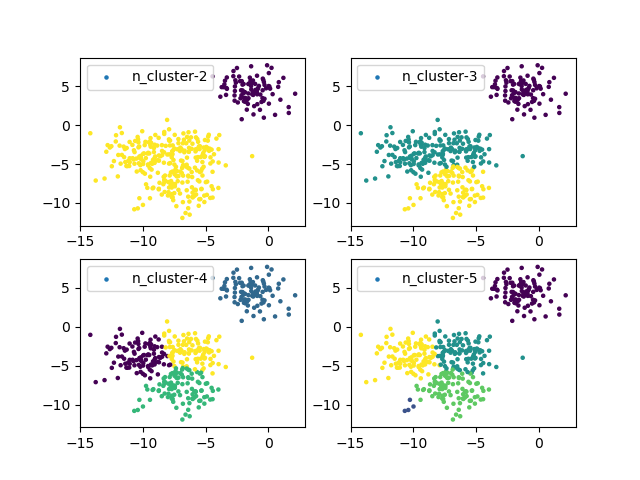

# Hyper parameter Tuning for kmeans



## Silhouette Score method

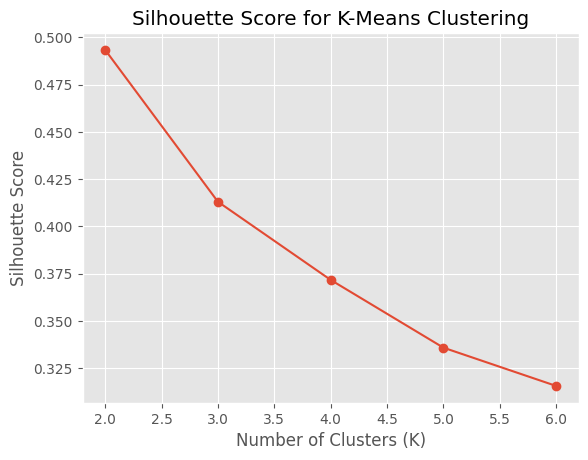

In [165]:
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X = data

# Define a range of K values to try
k_values = range(2, 7)

# Perform K-Means clustering for each K and calculate silhouette score
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X, labels))

# Plot the silhouette scores for different K values
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for K-Means Clustering')
plt.show()



## The elbow method
The elbow method is a common technique used to determine the optimal number of clusters in a K-Means clustering algorithm.
The elbow of the plot indicates a point where adding more clusters doesn't significantly improve the explained variance. The number of clusters corresponding to the elbow is a good candidate for the optimal number of clusters.

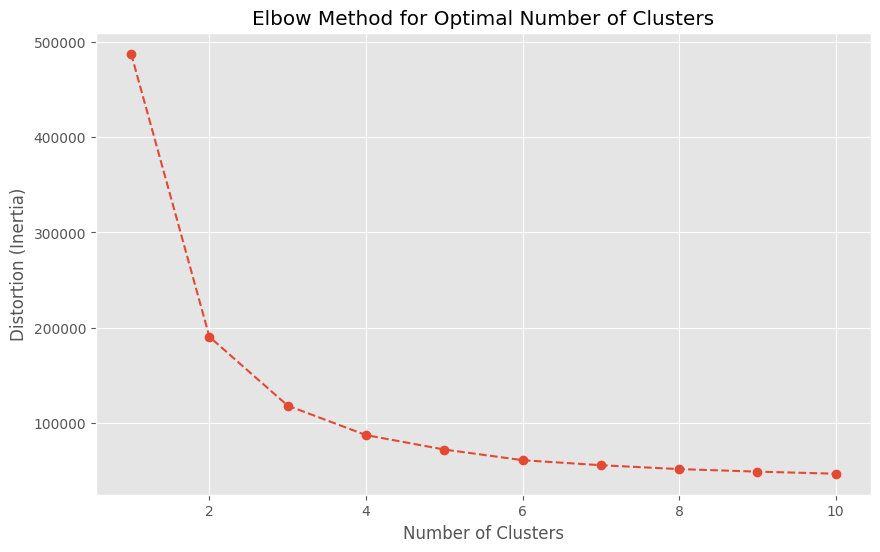

In [166]:
from sklearn.cluster import KMeans
# Elbow method to find the optimal number of clusters
def find_optimal_clusters(data, max_clusters=10):
    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), distortions, marker='o', linestyle='--')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion (Inertia)')
    plt.show()

# Call the function with your data
find_optimal_clusters(data, max_clusters=10)

The silhouette score is a metric used to calculate the goodness of a clustering technique, such as K-Means clustering. It measures how well-separated the clusters are in the data. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

## Changing from Random to RSI based clustering -
We would like to follow stocks momentum, and we are using RSI as the main indicator. Stocks which are around 70 RSI are in an upward momentum. in out strategy we would like to invest in the stocks that had the highest momentum throughout the previous month. For the purpose we are focusing on stocks clustered around 65-75 RSI, Therefore using the random initisalisation of the clusters wont work, so we help the clustering algorithm by supplying initial centroids

### Apply pre-defined centroids.

In [167]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 19))
#read documentaton of kmeans for this

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]])

Defining a function to get clusters of our stocks for each month

In [168]:
from sklearn.cluster import KMeans

# data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  \
date       ticker                                                  
2017-03-31 ADANIENT.NS   -0.730948  4.094287  3.917253  4.005770   
           ADANIPORTS.NS -0.935862  5.799313  5.645352  5.722332   
           APOLLOHOSP.NS -1.041104  7.122516  7.012271  7.067394   
           ASIANPAINT.NS -1.200976  6.956817  6.874274  6.915546   
           AXISBANK.NS   -0.962820  6.255885  6.165180  6.210532   
...                            ...       ...       ...       ...   
2024-02-29 TECHM.NS       1.132356  7.236102  7.159317  7.197710   
           TITAN.NS       2.384138  8.269666  8.155348  8.212507   
           ULTRACEMCO.NS  2.474421  9.233623  9.186445  9.210034   
           UPL.NS        -0.116624  6.394586  6.105863  6.250225   
           WIPRO.NS       1.756052  6.230686  6.138975  6.184831   

                          garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                            
2017-03-31 ADANIENT.NS            0.001078 -0.128790  67.437676   0.102031   
           ADANIPORTS.NS         -0.000675  0.279592  68.082276   0.125435   
           APOLLOHOSP.NS          0.000025 -0.622978  39.940351  -0.104867   
           ASIANPAINT.NS         -0.000628  0.200958  61.406746   0.048135   
           AXISBANK.NS            0.000067 -0.236393  47.576604  -0.031284   
...                                    ...       ...        ...        ...   
2024-02-29 TECHM.NS               0.000340  0.364820  54.226721  -0.003899   
           TITAN.NS               0.000063 -1.361541  44.584182  -0.037214   
           ULTRACEMCO.NS          0.000071 -0.010558  49.550379  -0.030977   
           UPL.NS                 0.001273 -2.228064  33.891326  -0.108983   
           WIPRO.NS               0.000791  1.451753  66.187070   0.069957   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2017-03-31 ADANIENT.NS     0.116044   0.123470   0.087287   0.025222   
           ADANIPORTS.NS   0.075947   0.081521   0.047714   0.056632   
           APOLLOHOSP.NS  -0.026738  -0.004184  -0.019764  -0.013395   
           ASIANPAINT.NS   0.051619   0.064061  -0.012524   0.007820   
           AXISBANK.NS     0.026265   0.029390  -0.016205  -0.008201   
...                             ...        ...        ...        ...   
2024-02-29 TECHM.NS        0.021688   0.028527   0.018637   0.026718   
           TITAN.NS       -0.015838   0.006579   0.023081   0.026466   
           ULTRACEMCO.NS  -0.031469   0.030484   0.029042   0.025795   
           UPL.NS         -0.096763  -0.056623  -0.034420  -0.037220   
           WIPRO.NS        0.042988   0.074693   0.038632   0.026926   

                          return_12m    Mkt-RF       SMB       HML       RMW  \
date       ticker                                                              
2017-03-31 ADANIENT.NS      0.032677  0.399011 -0.558664  0.362638  1.831222   
           ADANIPORTS.NS    0.026645  0.233206  0.111426  0.483611  0.316408   
           APOLLOHOSP.NS   -0.010923  0.376735 -0.403773  0.228662 -0.186724   
           ASIANPAINT.NS    0.018488  0.120956  0.165311  0.185990  0.403778   
           AXISBANK.NS      0.009140  0.845733  0.197412  0.411331 -0.412963   
...                              ...       ...       ...       ...       ...   
2024-02-29 TECHM.NS         0.021147  0.690843 -0.483017  0.317151 -0.475529   
           TITAN.NS         0.034663  0.362383  0.192167  0.369951  0.732616   
           ULTRACEMCO.NS    0.026146  0.357650 -0.134724  0.678711  0.242671   
           UPL.NS          -0.029115  0.605168  0.197132  0.261041  0.620227   
           WIPRO.NS         0.023703  0.490731 -0.307123  0.262648 -0.075336   

                               CMA  cluster  
date       ticker                            
2017-03-31 ADANIENT.NS   -0.459757        3  
           ADAN

## Defining a function to plot clusters for each month to group our data.

In [169]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return


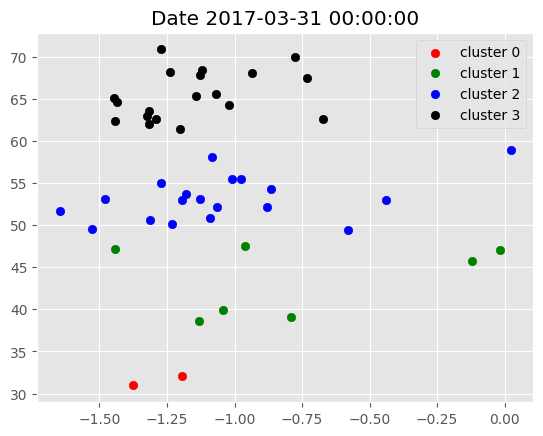

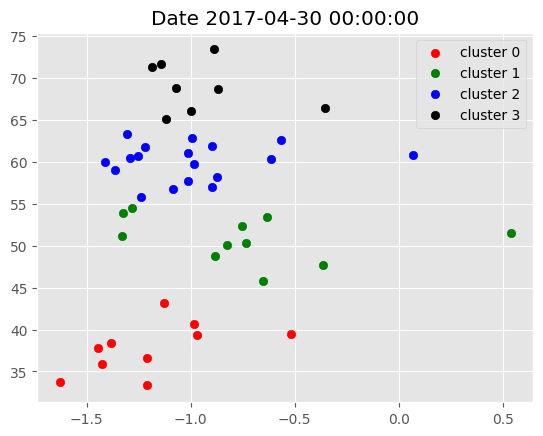

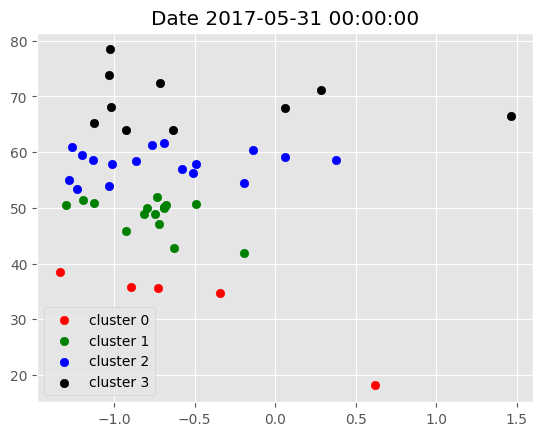

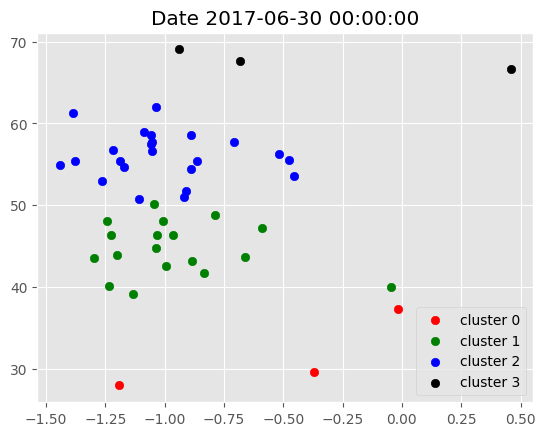

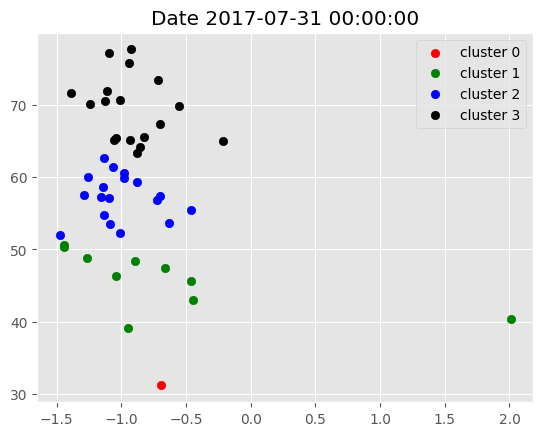

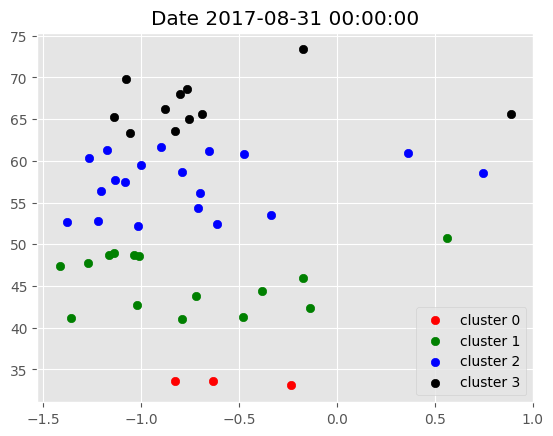

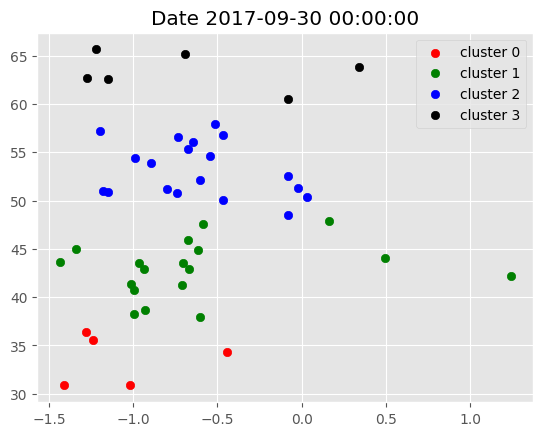

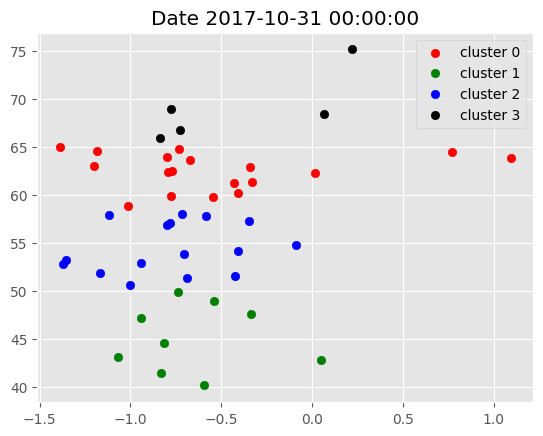

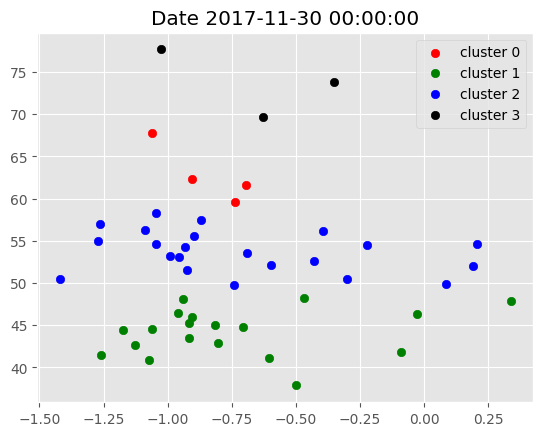

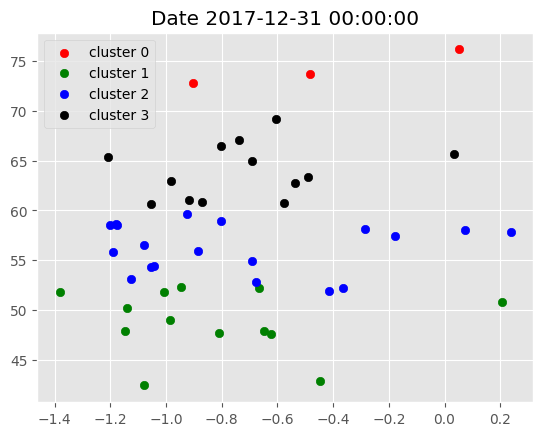

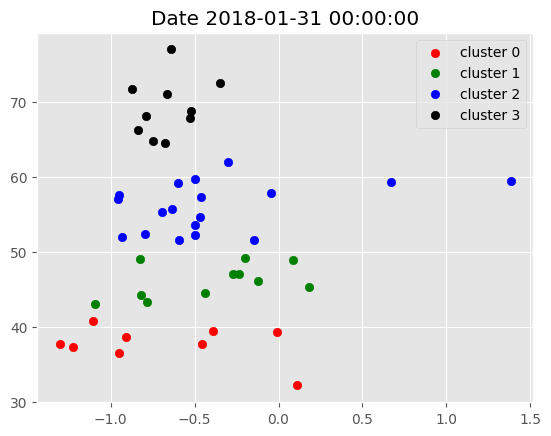

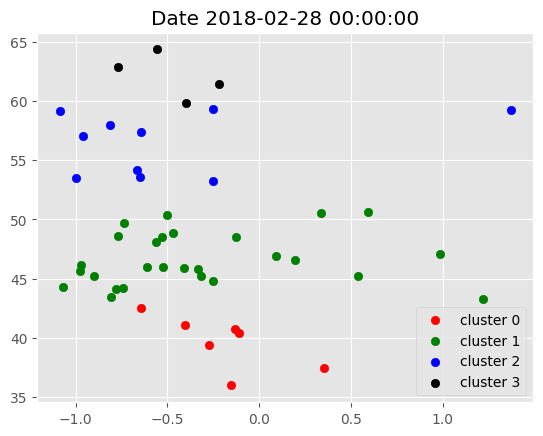

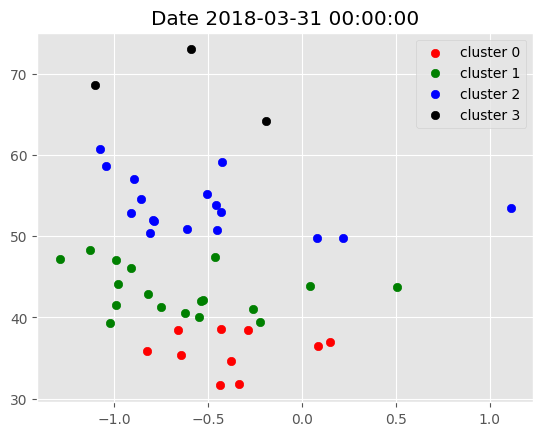

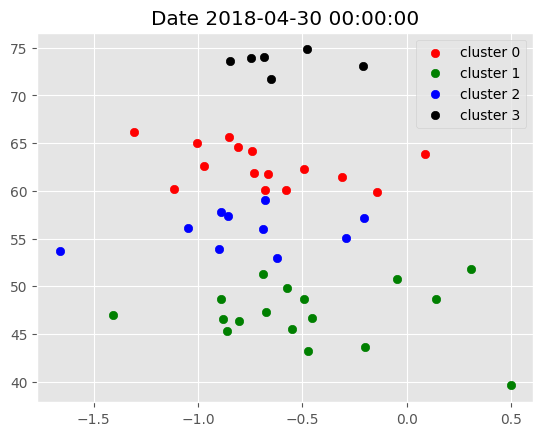

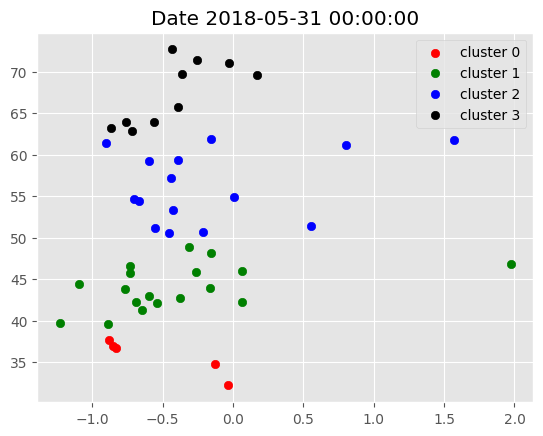

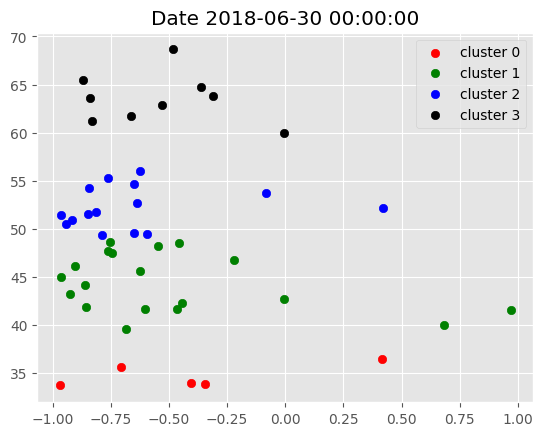

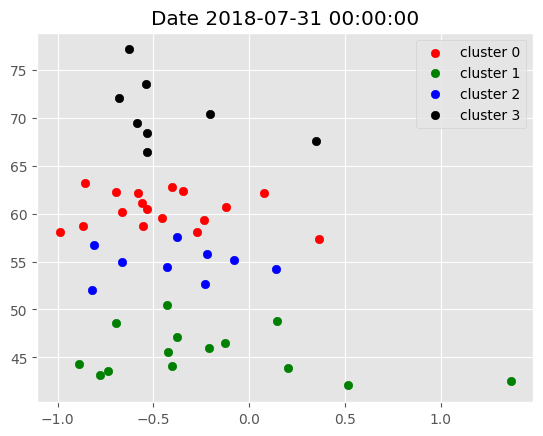

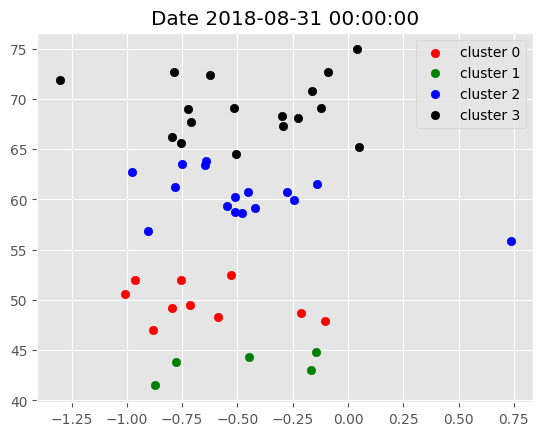

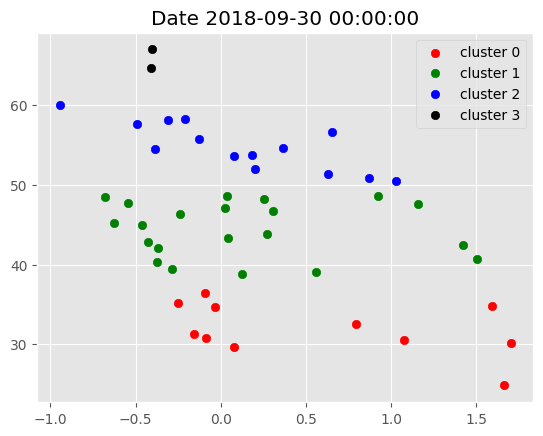

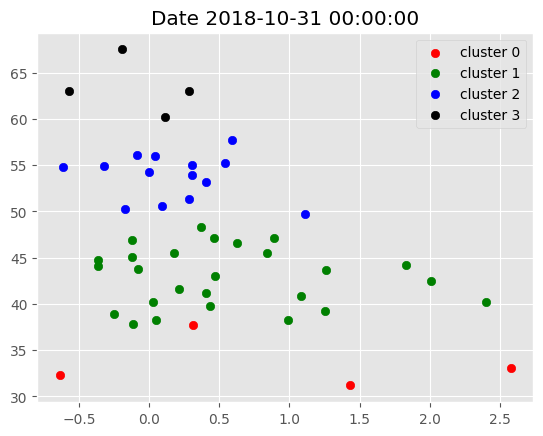

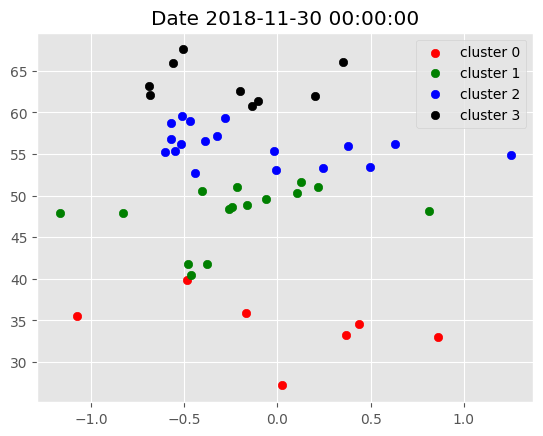

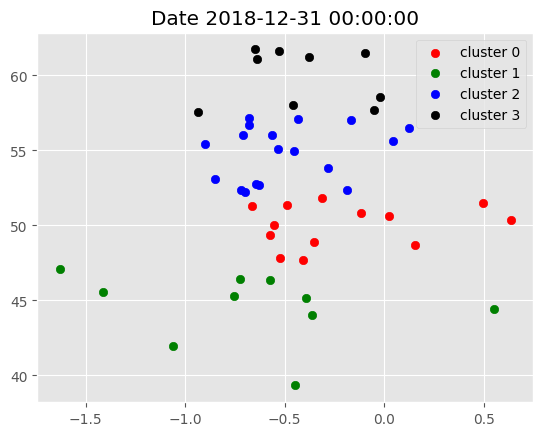

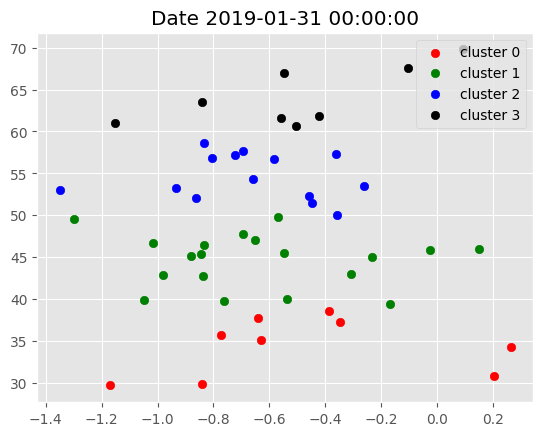

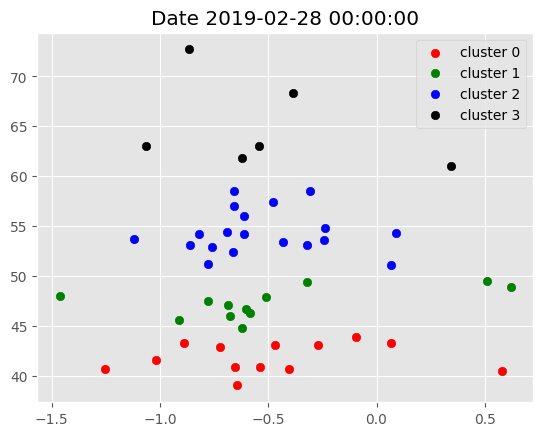

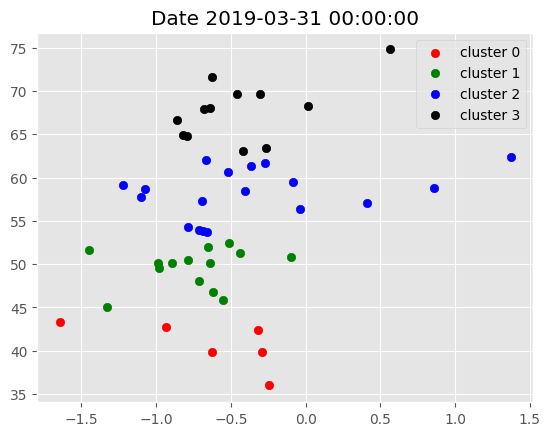

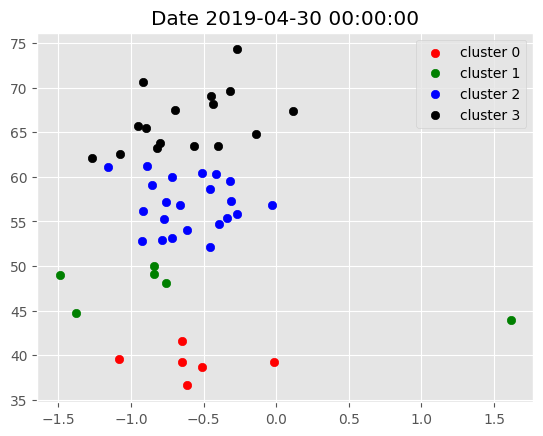

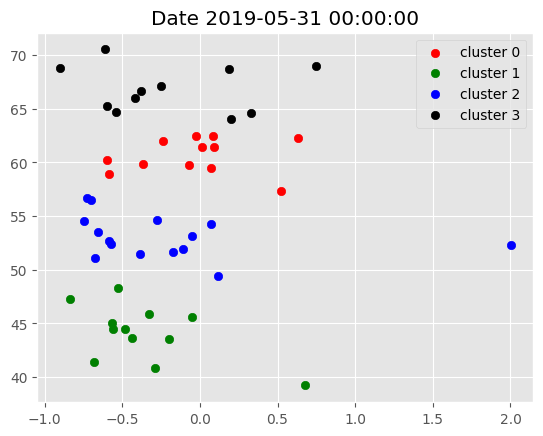

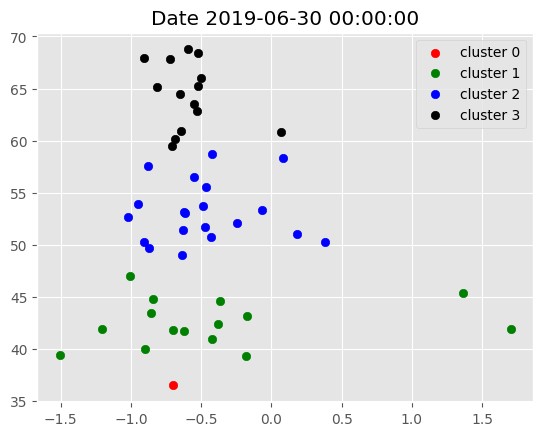

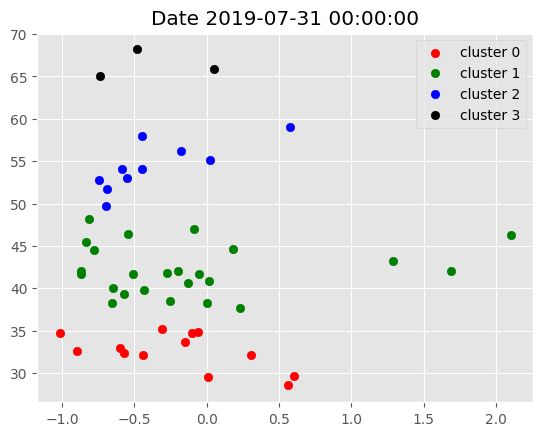

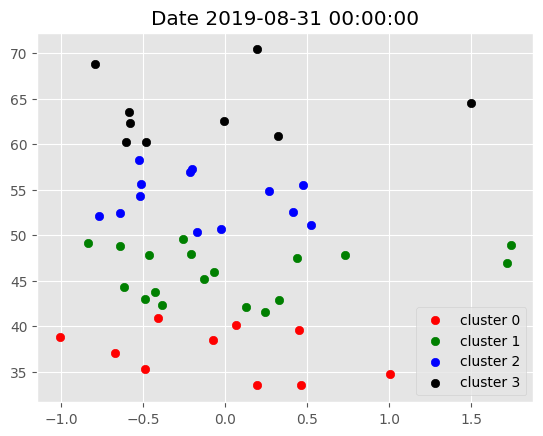

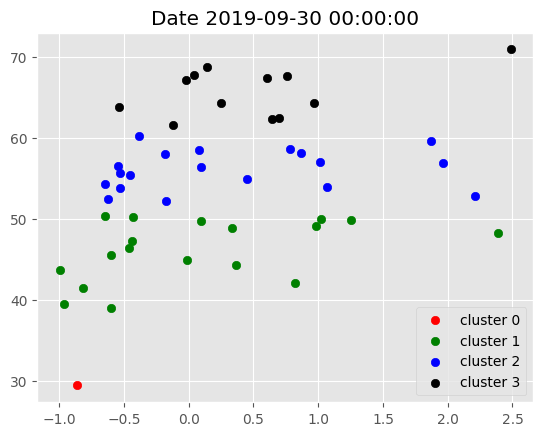

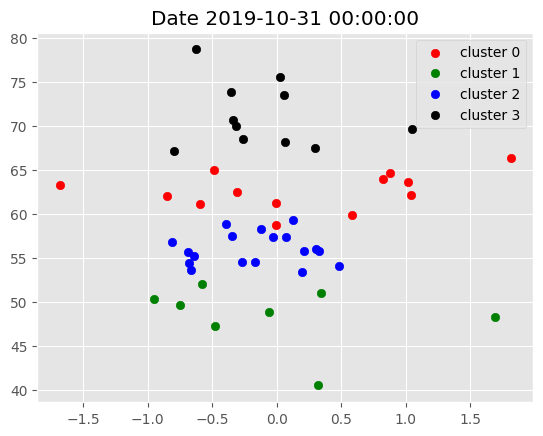

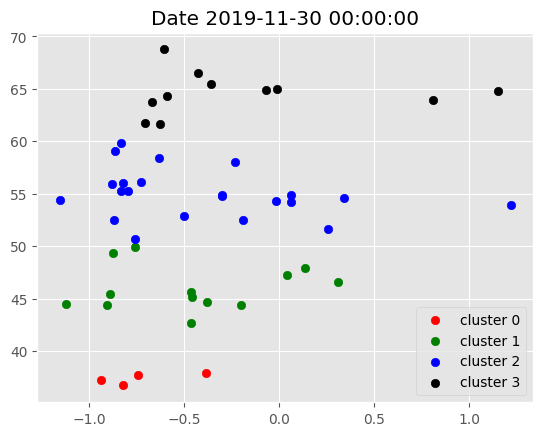

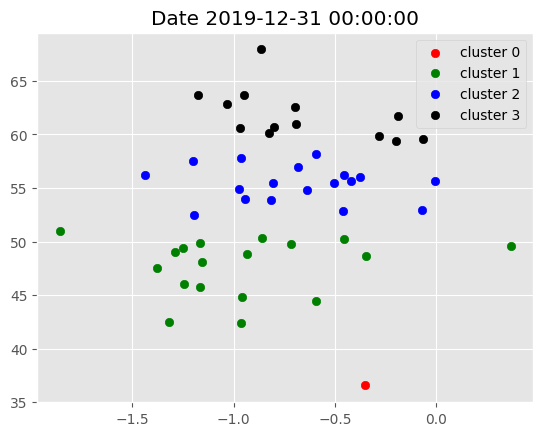

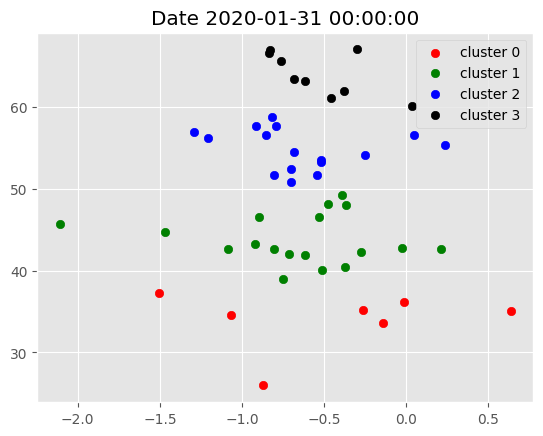

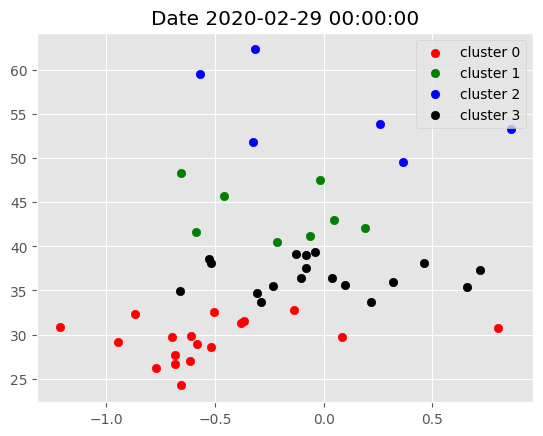

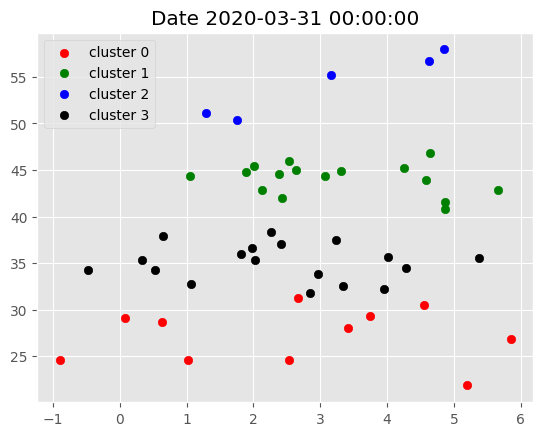

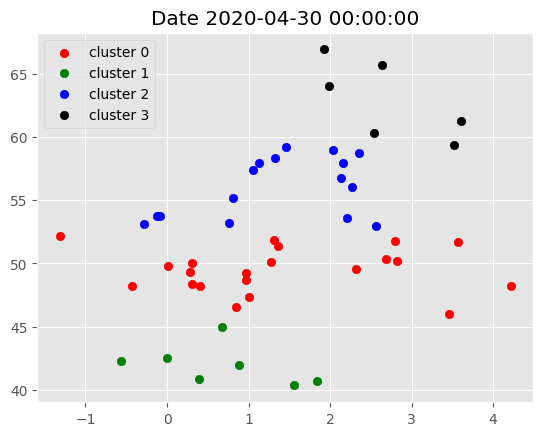

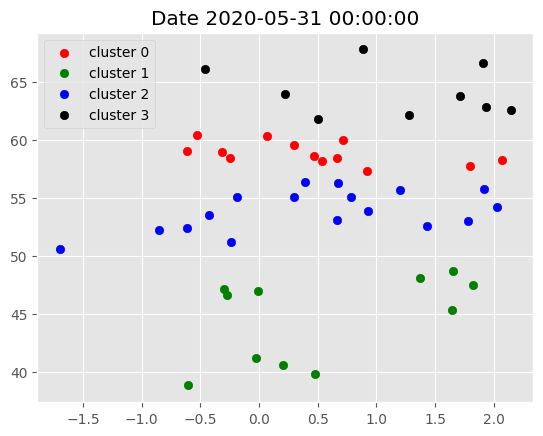

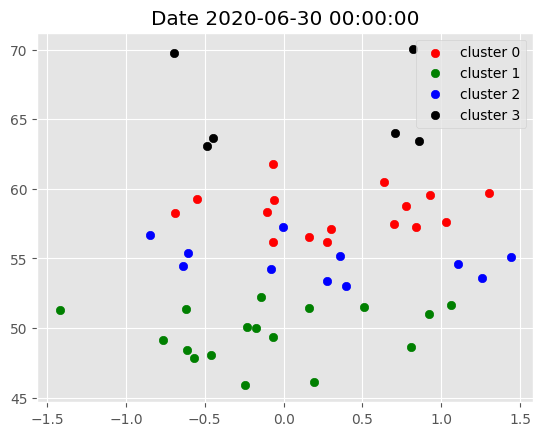

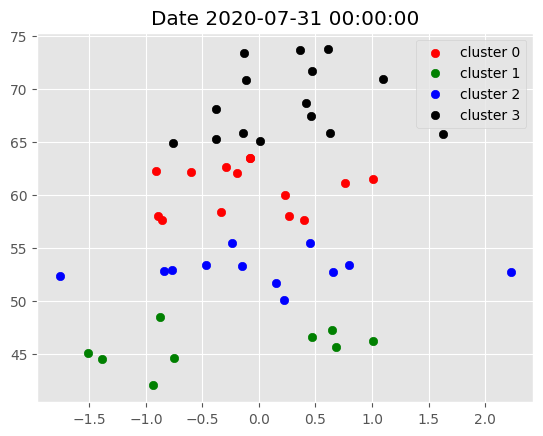

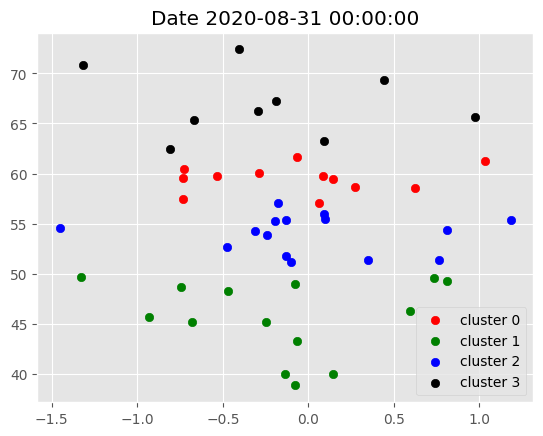

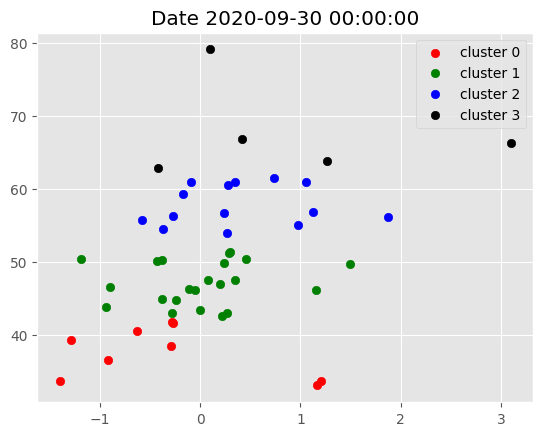

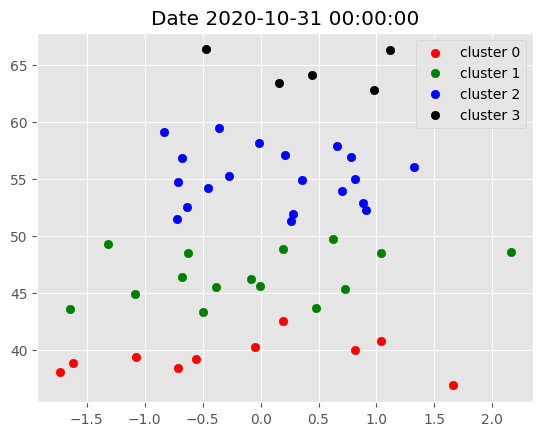

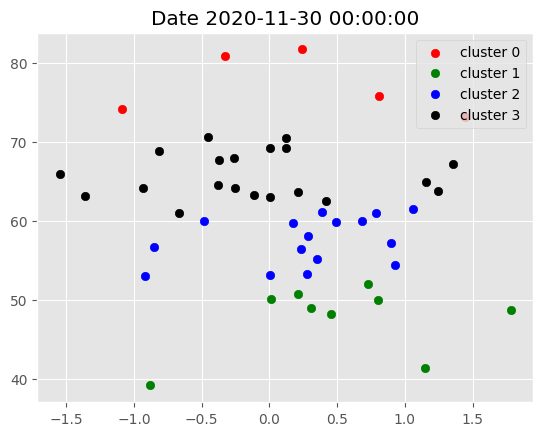

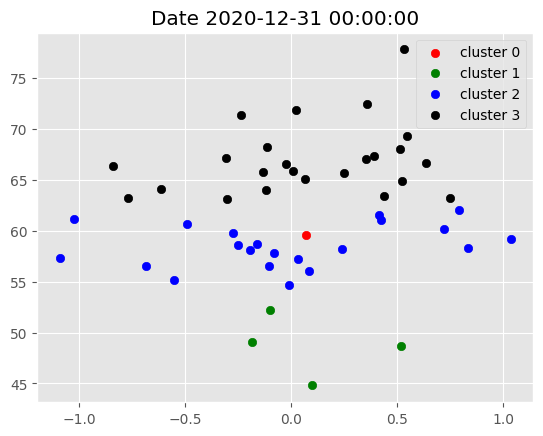

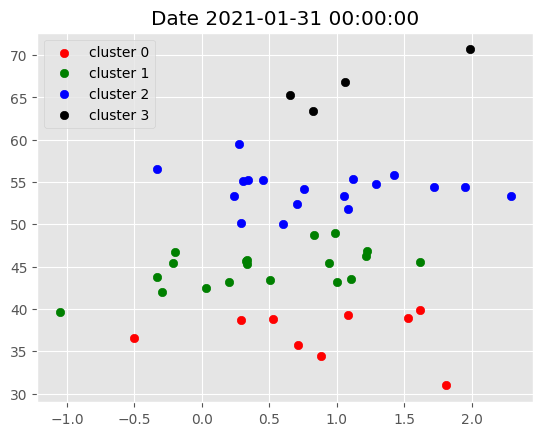

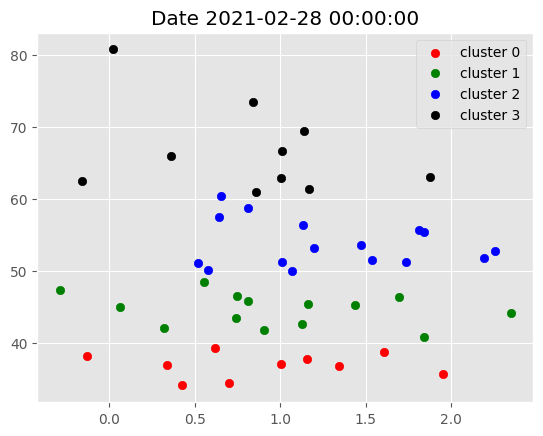

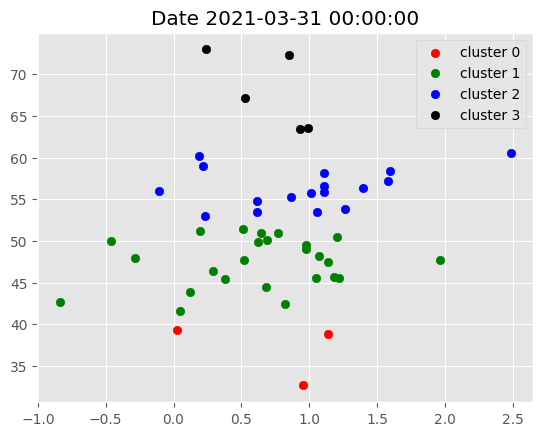

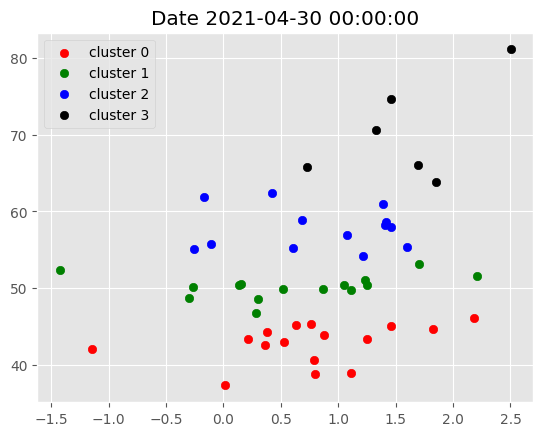

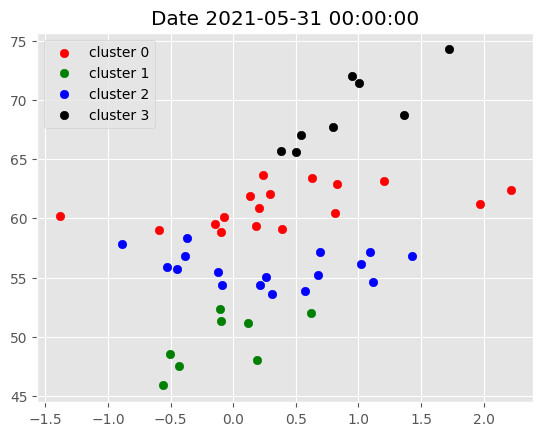

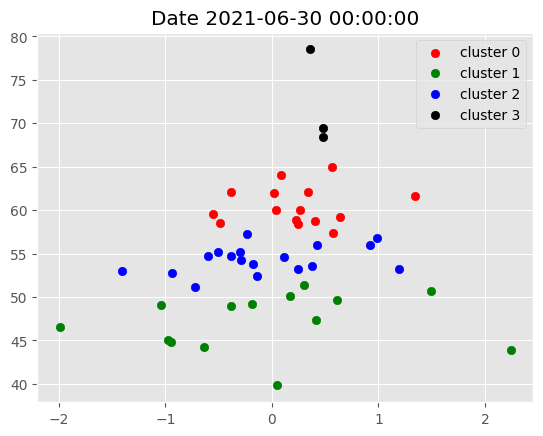

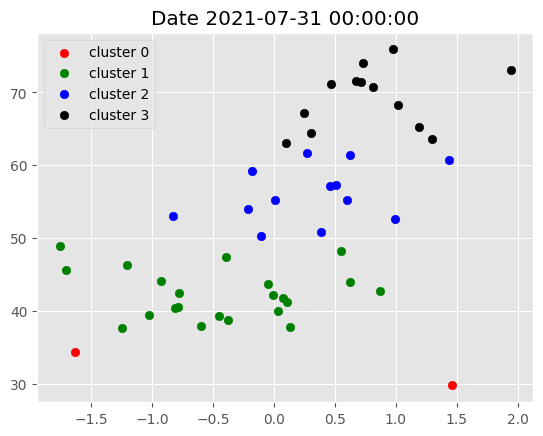

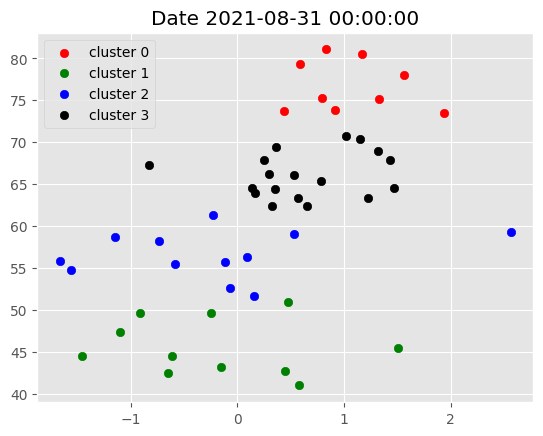

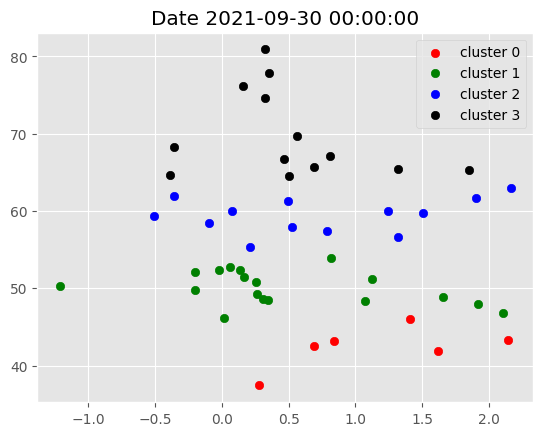

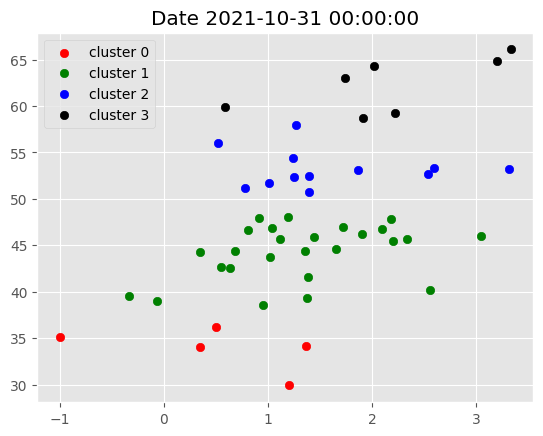

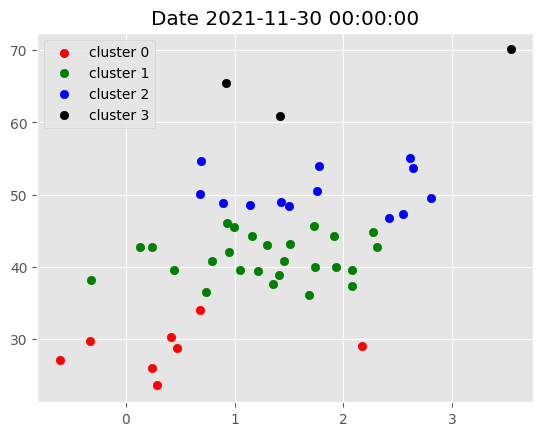

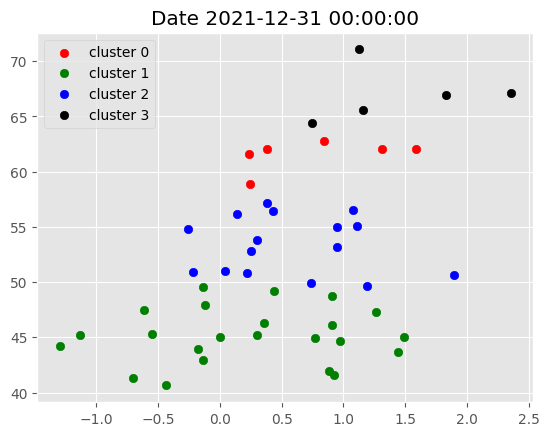

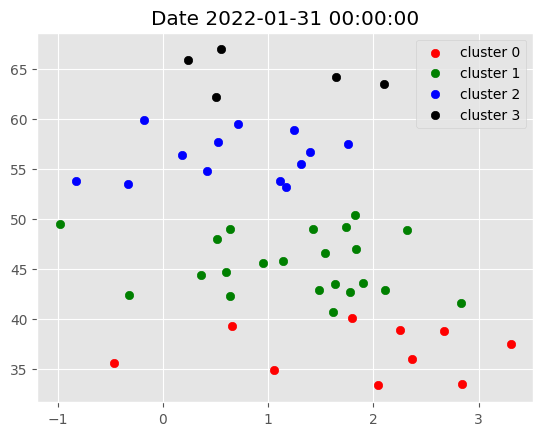

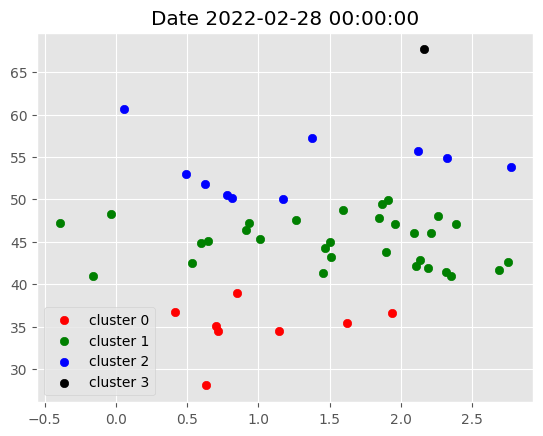

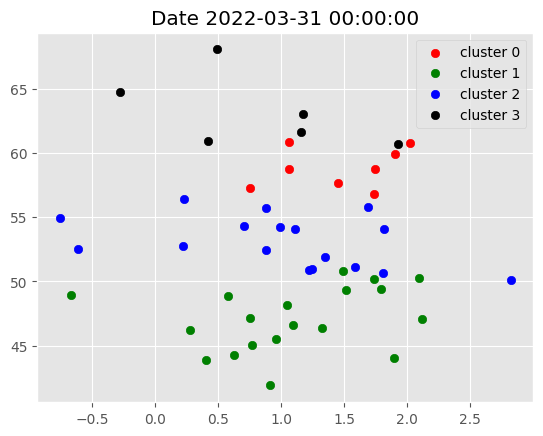

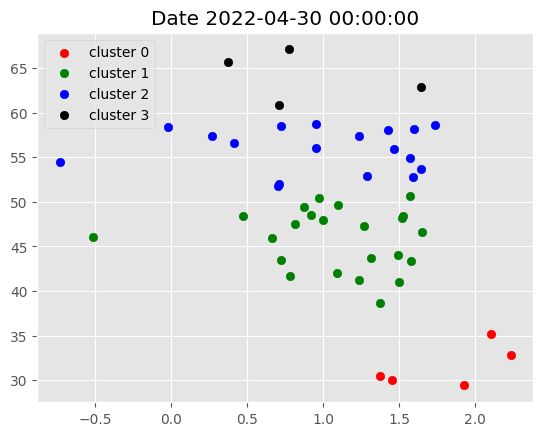

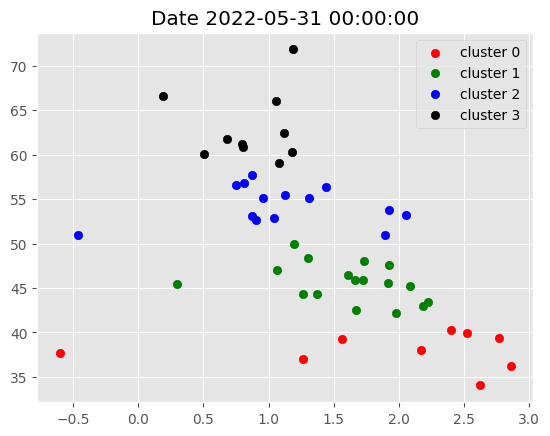

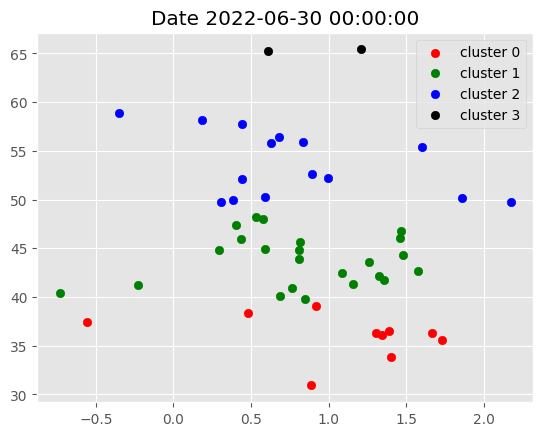

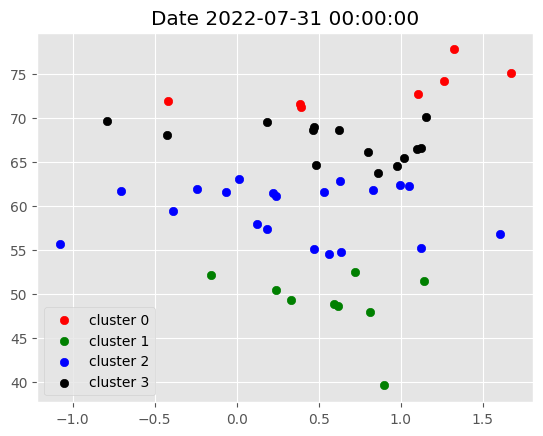

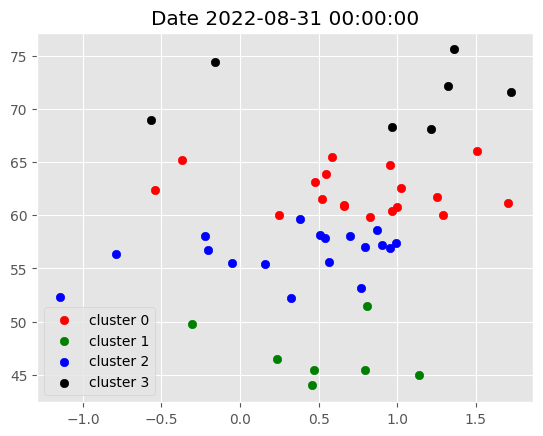

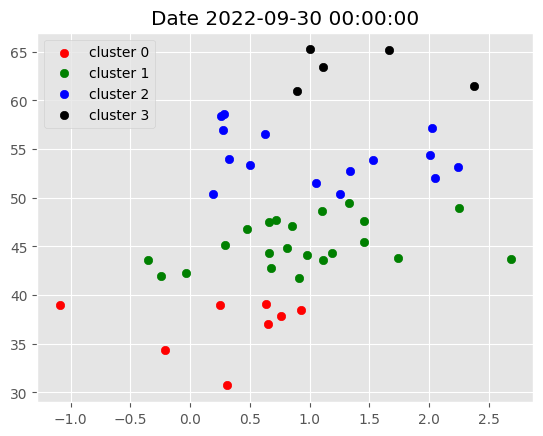

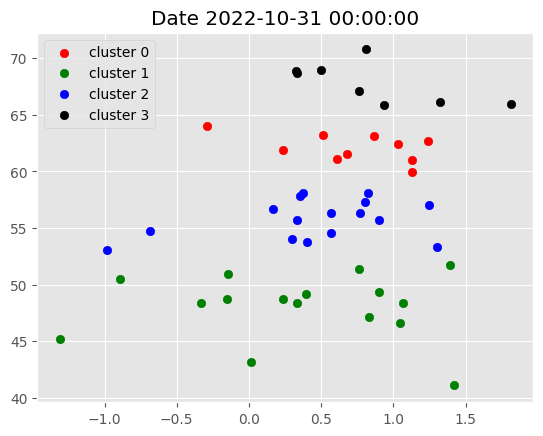

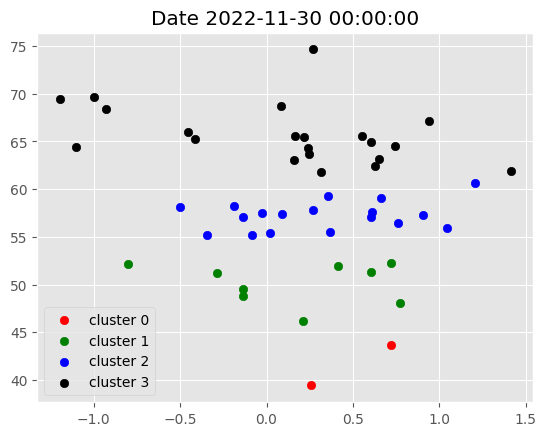

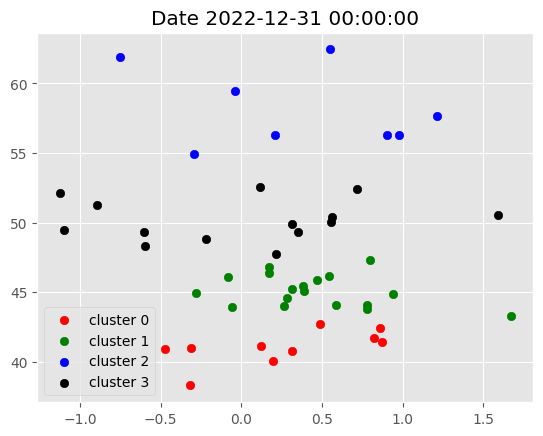

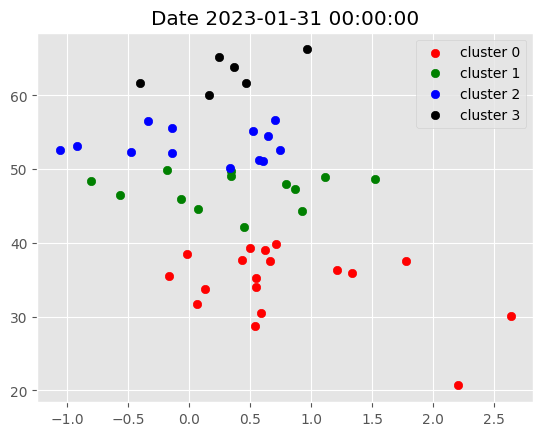

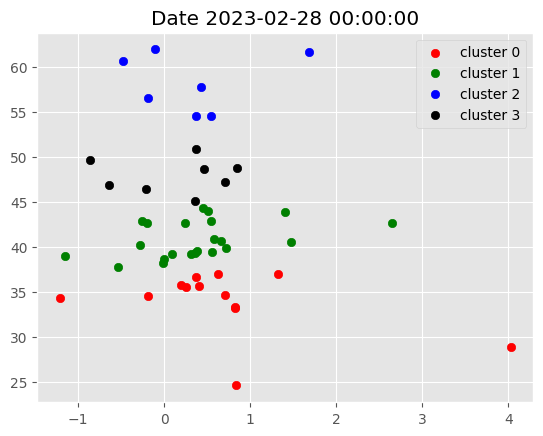

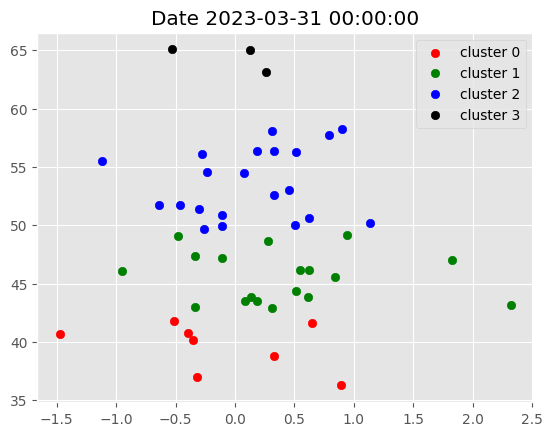

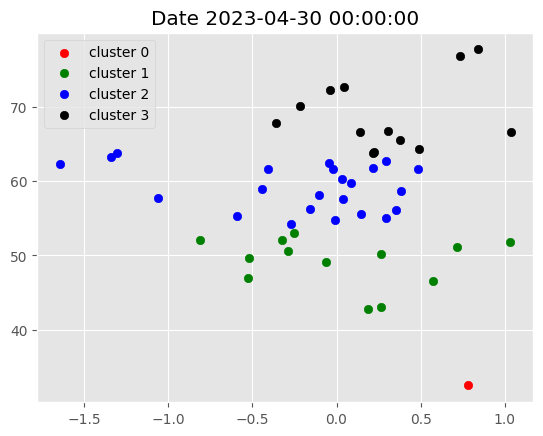

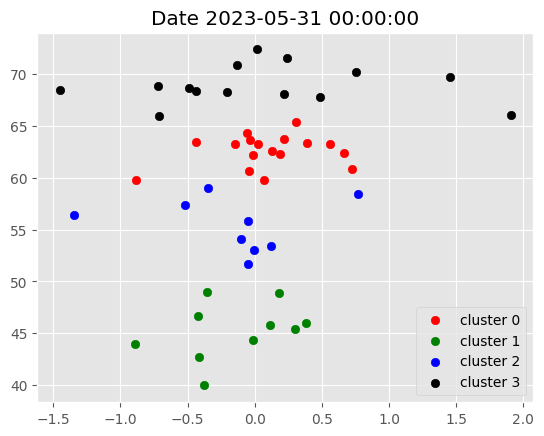

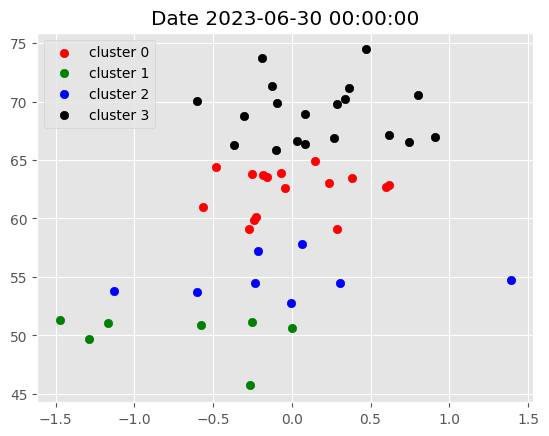

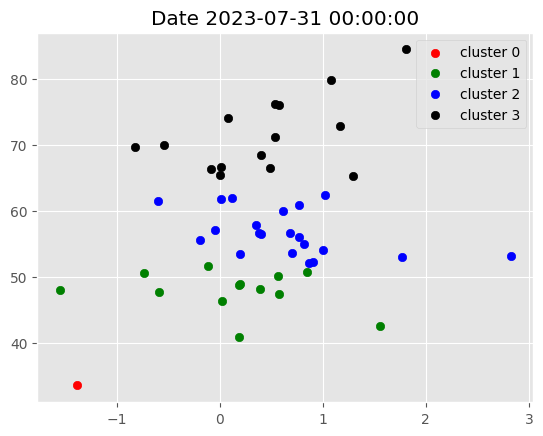

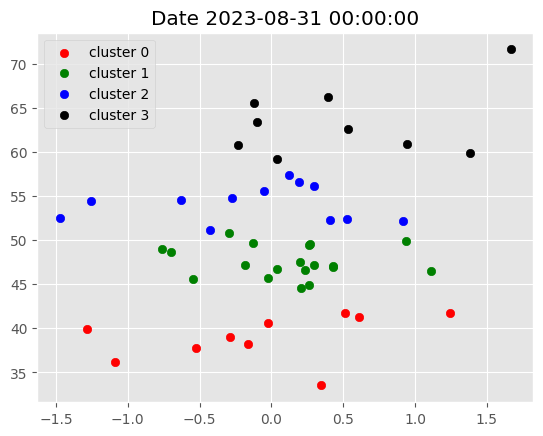

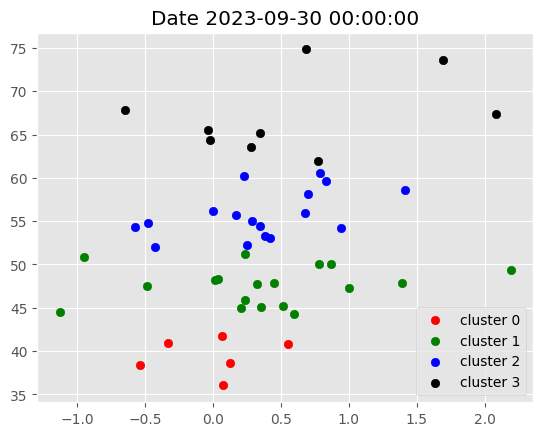

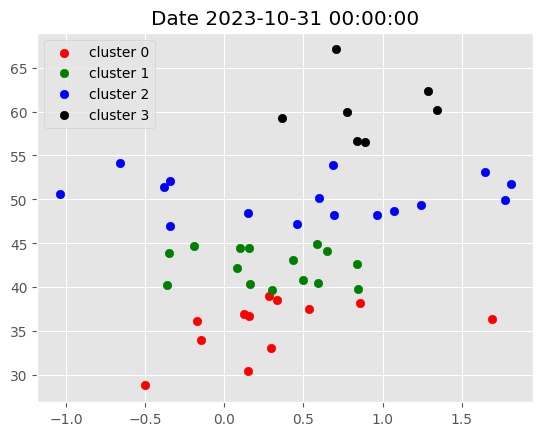

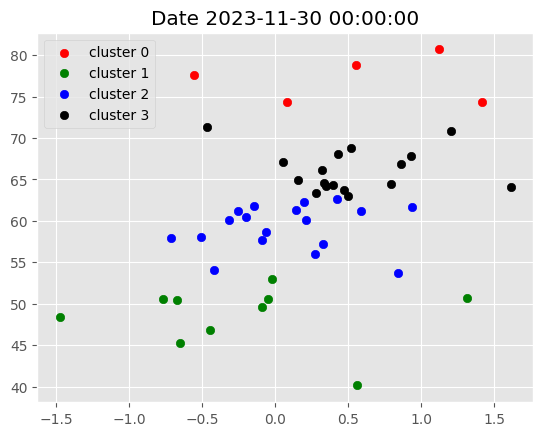

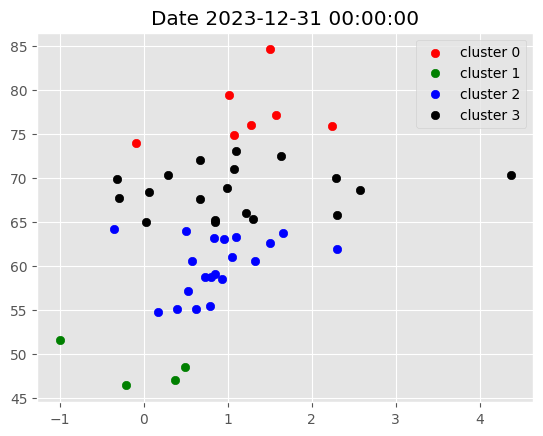

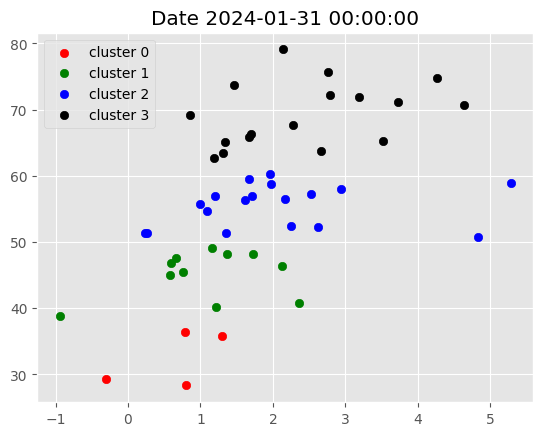

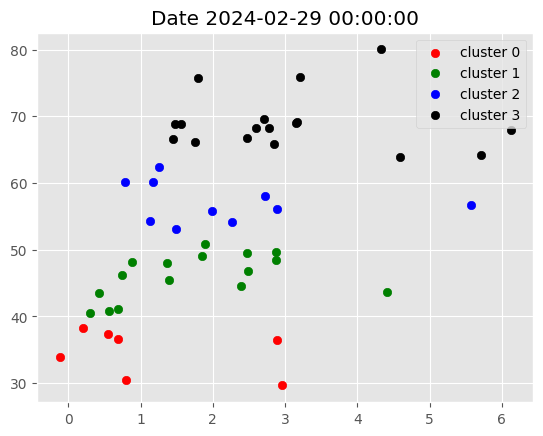

In [170]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
* The Efficient Frontier is a concept in financial portfolio theory that represents a set of optimal portfolios that offer the highest expected return for a given level of risk, or the lowest risk for a given level of expected return. The portfolios on the Efficient Frontier are considered efficient because they provide the maximum return for a given level of risk, or the minimum risk for a given level of return.

    The Sharpe Ratio is a measure of the risk-adjusted return of a portfolio. It calculates the excess return (return above the risk-free rate) per unit of risk (standard deviation of the portfolio's return).

## The maximum Sharpe Ratio portfolio is the point on the Efficient Frontier where the Sharpe Ratio is maximized.


* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [171]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2017-04-01': ['ADANIENT.NS',
  'ADANIPORTS.NS',
  'ASIANPAINT.NS',
  'BAJAJFINSV.NS',
  'BAJFINANCE.NS',
  'BRITANNIA.NS',
  'EICHERMOT.NS',
  'HDFCBANK.NS',
  'HINDUNILVR.NS',
  'INDUSINDBK.NS',
  'KOTAKBANK.NS',
  'LT.NS',
  'NESTLEIND.NS',
  'RELIANCE.NS',
  'SBIN.NS',
  'TATACONSUM.NS',
  'TITAN.NS',
  'ULTRACEMCO.NS',
  'WIPRO.NS'],
 '2017-05-01': ['ASIANPAINT.NS',
  'BAJAJFINSV.NS',
  'BRITANNIA.NS',
  'HDFCBANK.NS',
  'LT.NS',
  'MARUTI.NS',
  'ULTRACEMCO.NS',
  'UPL.NS'],
 '2017-06-01': ['HDFCBANK.NS',
  'HEROMOTOCO.NS',
  'HINDUNILVR.NS',
  'ICICIBANK.NS',
  'ITC.NS',
  'KOTAKBANK.NS',
  'M&M.NS',
  'MARUTI.NS',
  'UPL.NS',
  'WIPRO.NS'],
 '2017-07-01': ['GRASIM.NS', 'ITC.NS', 'TATASTEEL.NS'],
 '2017-08-01': ['ADANIPORTS.NS',
  'BAJAJFINSV.NS',
  'BAJFINANCE.NS',
  'BHARTIARTL.NS',
  'BRITANNIA.NS',
  'EICHERMOT.NS',
  'GRASIM.NS',
  'HDFCBANK.NS',
  'HINDALCO.NS',
  'HINDUNILVR.NS',
  'INDUSINDBK.NS',
  'KOTAKBANK.NS',
  'MARUTI.NS',
  'POWERGRID.NS',
  'RELIANCE.NS',
  'SB

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply single stock weight bounds constraint for diversification (minimum half of equally weight and maximum 10% of portfolio).

# Optimised weights

In [172]:
!pip install PyPortfolioOpt

In [173]:


from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=241)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=241)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [174]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  50 of 50 completed


Price         Adj Close                                            \
Ticker      ADANIENT.NS ADANIPORTS.NS APOLLOHOSP.NS ASIANPAINT.NS   
Date                                                                
2016-03-31    39.402481    237.887405   1296.622803    822.555908   
2016-04-01    40.630470    233.277557   1315.789673    824.071350   
2016-04-04    43.006363    232.941422   1321.057007    839.368774   
2016-04-05    39.749523    217.287125   1314.131592    823.929260   
2016-04-06    40.310123    215.462433   1315.984985    817.725037   
...                 ...           ...           ...           ...   
2024-02-22  3263.050049   1310.949951   6769.200195   3017.399902   
2024-02-23  3273.300049   1320.699951   6774.049805   2985.949951   
2024-02-26  3327.750000   1338.150024   6584.000000   2868.449951   
2024-02-27  3302.300049   1329.449951   6620.600098   2859.550049   
2024-02-28  3219.000000   1299.500000   6362.350098   2794.350098   

Price                                                              \
Ticker      AXISBANK.NS BAJAJ-AUTO.NS BAJAJFINSV.NS BAJFINANCE.NS   
Date                                                                
2016-03-31   434.108917   1893.576416    170.553802    676.747192   
2016-04-01   439.728943   1904.516235    174.107208    672.187805   
2016-04-04   434.695343   1926.868164    174.560745    671.425354   
2016-04-05   422.820038   1884.840454    174.311539    666.914856   
2016-04-06   415.049805   1885.115845    175.971130    679.034302   
...                 ...           ...           ...           ...   
2024-02-22  1100.900024   8498.450195   1592.550049   6674.950195   
2024-02-23  1096.800049   8436.950195   1616.550049   6697.850098   
2024-02-26  1085.199951   8448.000000   1614.300049   6643.250000   
2024-02-27  1079.050049   8463.500000   1600.599976   6556.250000   
2024-02-28  1074.199951   8188.649902   1584.500000   6498.700195   

Price                                 ...       Volume                \
Ticker     BHARTIARTL.NS     BPCL.NS  ... SUNPHARMA.NS TATACONSUM.NS   
Date                                  ...                              
2016-03-31    303.655457  192.524002  ...      5230705       1627181   
2016-04-01    290.368347  188.894073  ...      1654746       1532533   
2016-04-04    301.664551  188.840805  ...      1239310        831737   
2016-04-05    286.083588  189.564682  ...      2570634       1663091   
2016-04-06    289.546021  189.511475  ...      1809628       1327276   
...                  ...         ...  ...          ...           ...   
2024-02-22   1135.550049  625.900024  ...      1981678       1689403   
2024-02-23   1125.750000  617.950012  ...      1340283       1280859   
2024-02-26   1110.050049  627.150024  ...       974892       1292210   
2024-02-27   1127.500000  625.049988  ...      2140963       1584564   
2024-02-28   1128.750000  609.299988  ...       578316       2170054   

Price                                                             \
Ticker     TATAMOTORS.NS TATASTEEL.NS   TCS.NS TECHM.NS TITAN.NS   
Date                                                               
2016-03-31      10738707    140121880  4363964  4630177   895578   
2016-04-01       5683771     58463365  3041400  2394963   517494   
2016-04-04       6011729     54242901  1752352  1708093   796436   
2016-04-05       6058241     60071721  1491794  1430387   829255   
2016-04-06       7323269    153148901  1763150  2671558  1075449   
...                  ...          ...      ...      ...      ...   
2024-02-22       6437014     46728176  2982052  2201424  1017437   
2024-02-23       7047473     28414697  2538072  1660506   897831   
2024-02-26       5600234     22570277  1379284  1196507   546842   
2024-02-27      12810206     24119469  2960475  1488661   673959   
2024-02-28      15219187     20721926  1939225  1289779   538608   

Price                                        
Ticker     ULTRACEMCO.NS   UPL.NS  WIPRO.NS  
Date        

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [175]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2017-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-12-01, Continuing with Equal-Weights

,Strategy Return
date,
2017-04-03,0.004473
2017-04-05,0.011424
2017-04-06,0.004691
2017-04-07,-0.006089
2017-04-10,0.004564
...,...
2024-02-22,0.011023
2024-02-23,-0.001718
2024-02-26,-0.001246


## 8. Visualize Portfolio returns and compare to Nifty50 returns.

In [176]:
nift50 = yf.download(tickers='^NSEI',
                  start='2015-01-01',
                  end=dt.date.today())

nift50_ret = np.log(nift50[['Adj Close']]).diff().dropna().rename({'Adj Close':'Nifty50 Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(nift50_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,Nifty50 Buy&Hold
2017-04-03,0.004473,0.006963
2017-04-05,0.011424,0.002951
2017-04-06,0.004691,-0.000345
2017-04-07,-0.006089,-0.006896
2017-04-10,0.004564,-0.001833
...,...,...
2024-02-22,0.011023,0.007336
2024-02-23,-0.001718,-0.000214
2024-02-26,-0.001246,-0.004089
2024-02-27,0.005682,0.003443


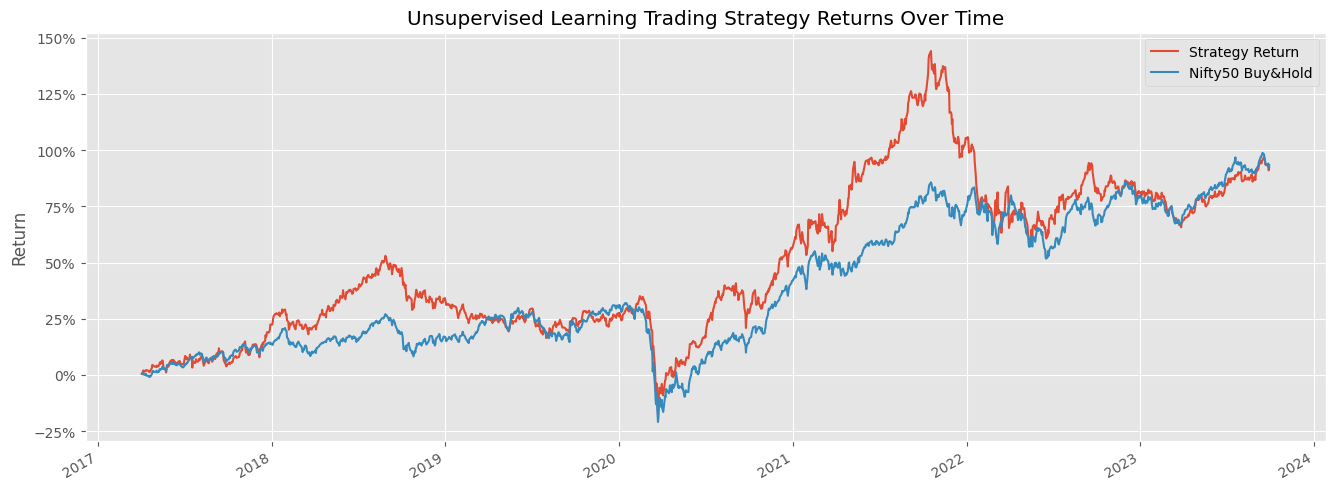

In [177]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


# Evaluation Metrics

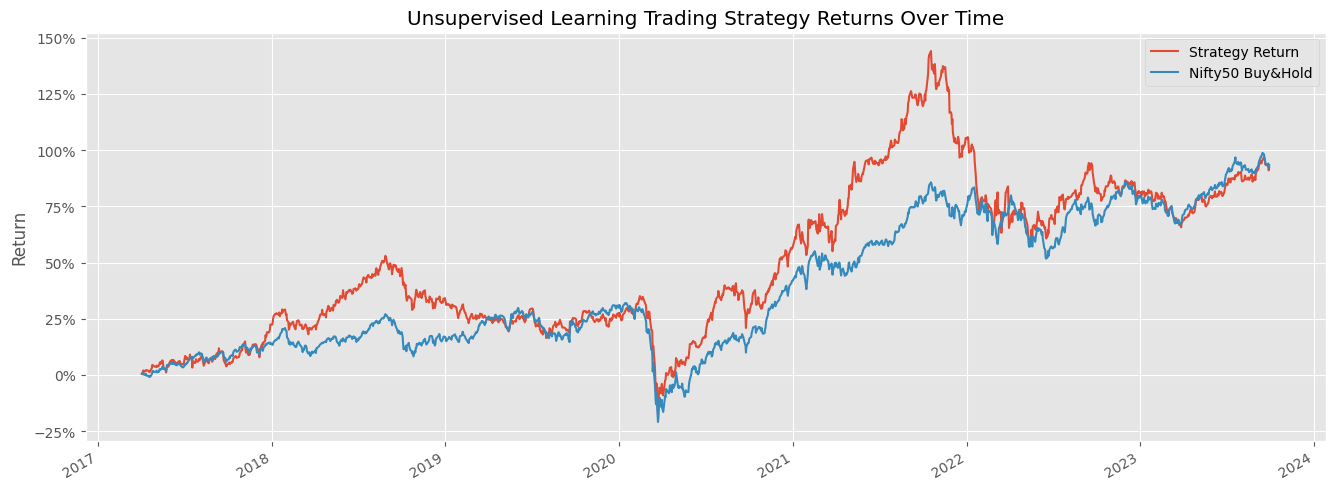

Total Return: 134.94%
Annualized Return: 12.84%
Annualized Volatility: 20.00%
Sharpe Ratio: 0.54
Max Drawdown: -133.02%


In [178]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np


# Calculate cumulative returns
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()) - 1

# Plot cumulative returns
portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16, 6))
plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()

# Calculate additional evaluation metrics
total_return = portfolio_cumulative_return.iloc[-1]
annualized_return = ((1 + total_return) ** (241 / len(portfolio_cumulative_return.index))) - 1  # 241 trading days left

# Calculate annualized volatility
annualized_volatility = portfolio_df.std() * np.sqrt(241)

# Calculate Sharpe ratio
risk_free_rate = 0.02  # Adjust with the appropriate risk-free rate
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# Calculate drawdown
cumulative_returns = np.exp(np.log1p(portfolio_df).cumsum()) - 1
rolling_max = cumulative_returns.expanding(min_periods=1).max()
drawdown = (cumulative_returns - rolling_max) / rolling_max
# Print metrics
print('Total Return: {:.2%}'.format(total_return.values[0]))
print('Annualized Return: {:.2%}'.format(annualized_return.values[0]))
print('Annualized Volatility: {:.2%}'.format(annualized_volatility.values[0]))
print('Sharpe Ratio: {:.2f}'.format(sharpe_ratio.values[0]))
print('Max Drawdown: {:.2%}'.format(drawdown.min().values[0]))